In [65]:
library(ggplot2)
library(gridExtra)
library(scales)
library(dplyr)
library(glue)
library(stringr)
library(comprehenr)
library(purrr)
library(tibble)

## es1

First of all, to calculate the posterior we start from the Bayes's theorem, which in this case has the following form (not normalized):
\begin{equation} 
P(\mu |{y_i} M ) \propto f({y_i} | \mu M ) \times g(\mu | M) 
\end{equation}

Since one single measurement follow the Poisson distribution ( $f(y | \mu) = \mu^y e^{-y} / \> y!$  ), the likelihood of multiple independent measurements like this is:
\begin{equation} 
f({y_i}| \mu) = \prod _{j=1} ^{n} f(y_i | \mu) \propto \mu^{\sum y_i} \times e^{-n \mu}
\end{equation}
This likelihood has looks like a Gamma distribution:
\begin{equation} 
Gamma(y| \alpha, \lambda) = k y^{\alpha -1} e^{-\lambda y}
\end{equation}
Remembering the Bayes's theorem, we have to situations due to the choice of the prior: uniform or Jeffrey's. In both cases the prior can be seen as Gamma distribution with particular $\alpha, \lambda$ values. So combining the likelihood we have a product between two gamma distribution which give another Gamma function $Gamma(\alpha, \lambda )$. The results are the following:

- Uniform Prior: $\alpha = \sum _k x_k + 1$ and $\lambda = n$
- Jeffrey's Prior: $\alpha = \sum _k x_k + \frac{1}{2}$ and $\lambda = n$ 

where $x_k$ are the measurements and n are the total number of samples

### Uniform Prior

In [66]:
# uniform prior
n_sample <- 1e4
particles <- c(4,1,3,1,3)
delta.p <- 1/n_sample

p <- seq(0,6,delta.p)
alpha_u <- 1 + sum(particles)
lambda <- length(particles)
norm_unif_posterior <- dgamma(p,alpha_u,lambda)/(delta.p*sum(dgamma(p,alpha_u,lambda)))


In [67]:
# plot(p, norm_unif_posterior)

About the median: to calculate it we follow its definition:
\begin{equation}
P(x \leq median) = P (x > median) = 0.5
\end{equation}
So we calculate it by imposing that the integral of the probability is 0.5, meaning to find the x such that:
\begin{equation}
\int_0^x Posterior(x) = 0.5
\end{equation}
or in particulary: $\int_0^x Posterior(x) - 0.5 = 0$

In [68]:
#mean, median, variance
#analytically
unif_mean <- alpha_u / lambda
unif_var  <- alpha_u / lambda^2
mode_a    <- p[which(norm_unif_posterior == max(norm_unif_posterior))][1]

#for the median:
unif_post <- function(p) {dgamma(p, alpha_u, lambda)}
# integral <- function(x) {return(integrate(unif_posterior, lower=0, upper=x)$value)}
median   <- uniroot( function(x) integrate(unif_post, lower=0, upper=x)$value - 0.5, c(0,6) )$root
print("Analitically:")
cat("\t mean =",unif_mean,"\n")
cat("\t variance =",unif_var,"\n")
cat("\t median =",median,"\n")

#numerically
mean_n <-  sum(p * norm_unif_posterior) / n_sample
var_n  <-  sum(p^2 * norm_unif_posterior) / n_sample - mean_n^2
print("Numerically:")
cat("\t mean =",mean_n,"\n")
cat("\t variance =",var_n,"\n")

[1] "Analitically:"
	 mean = 2.6 
	 variance = 0.52 
	 median = 2.533668 
[1] "Numerically:"
	 mean = 2.599377 
	 variance = 0.517757 


### Jeffrey's prior

In [69]:
alpha_j <- 1/2 + sum(particles)
lambda <- length(particles)

norm_jeff_posterior <- dgamma(p,alpha_j,lambda)/(delta.p*sum(dgamma(p,alpha_j,lambda)))


In [70]:
# plot(p, norm_jeff_posterior, col="tomato3")

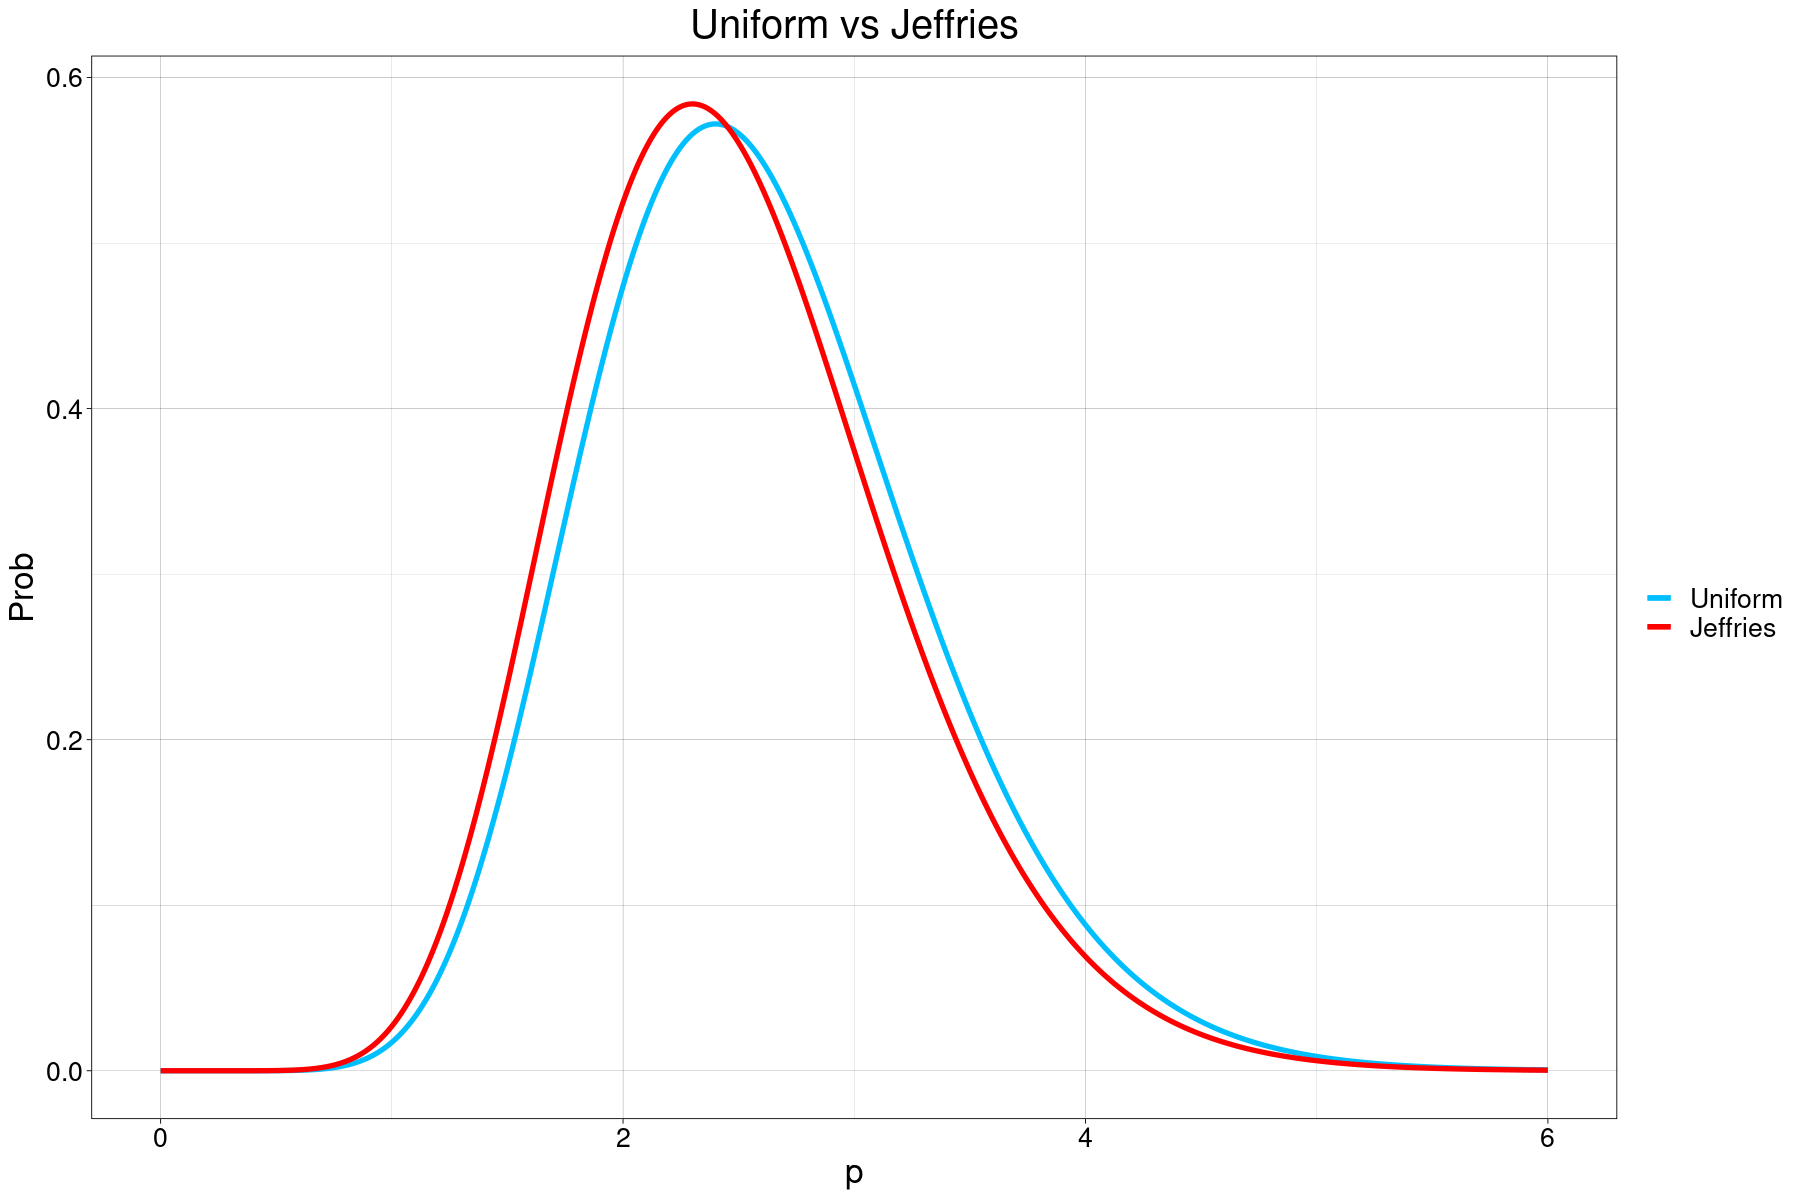

In [71]:
options(repr.plot.width=15, repr.plot.height=10)
pt <- ggplot() +
        geom_line(aes(x=p, y=norm_unif_posterior, color="Uniform"),lwd=1.5) + 
        geom_line(aes(x=p, y=norm_jeff_posterior, color="Jeffries"),lwd=1.5) + 
        theme_linedraw() +
        scale_color_manual(name = "", values = c("Uniform" = "deepskyblue", "Jeffries" = "red"))+
        labs(title=glue("Uniform vs Jeffries"), x="p",y="Prob")+
        theme(text = element_text(size=20), plot.title = element_text( hjust = 0.5))
pt

In [72]:
#mean, median, variance
#analytically
jeff_mean <- alpha_j / lambda
jeff_var  <- alpha_j / lambda^2
mode_a    <- p[which(norm_jeff_posterior == max(norm_jeff_posterior))][1]

#for the median:
Jeff_post <- function(p) {dgamma(p, alpha_j, lambda)}
median <- uniroot( function(x) integrate(Jeff_post, lower=0, upper=x)$value - 0.5, c(0,6) )$root

print("Analitically:")
cat("\t mean =",jeff_mean,"\n")
cat("\t variance =",jeff_var,"\n")
cat("\t median =",median,"\n")


#numerically
mean_n <- sum(p * norm_jeff_posterior) / n_sample
var_n  <- sum(p^2 * norm_jeff_posterior) / n_sample - mean_n^2
print("Numerically:")
cat("\t mean =",mean_n,"\n")
cat("\t variance =",var_n,"\n")

[1] "Analitically:"
	 mean = 2.5 
	 variance = 0.5 
	 median = 2.433661 
[1] "Numerically:"
	 mean = 2.499602 
	 variance = 0.4985269 


In [73]:
unif_low   <- p[cumsum(norm_unif_posterior / n_sample)> 0.025][1]
unif_high  <- p[cumsum(norm_unif_posterior / n_sample)> 0.975][1]

Jeff_low   <- p[cumsum(norm_jeff_posterior / n_sample)> 0.025][1]
Jeff_high  <- p[cumsum(norm_jeff_posterior / n_sample)> 0.975][1]


In [74]:
#comparing with normal posterior approximation
#first let's calculate the mean and the std of the norm function
#recall for the normal distribution the credibility interval of 95% corresponds to 2*sigma interval!!!!

unif_std  <- sqrt(unif_var)
low_unif_norm <- unif_mean - 2* unif_std
high_unif_norm <- unif_mean + 2* unif_std
unif_post_gauss <- dnorm(p, unif_mean, unif_std) / (sum(dnorm(p,unif_mean, unif_std)) / n_sample)

jeff_std  <- sqrt(jeff_var)
low_jeff_norm <- jeff_mean - 2* jeff_std
high_jeff_norm <- jeff_mean + 2* jeff_std
Jeff_post_gauss <- dnorm(p, jeff_mean, jeff_std) / (sum(dnorm(p,jeff_mean, jeff_std)) / n_sample)

## plot

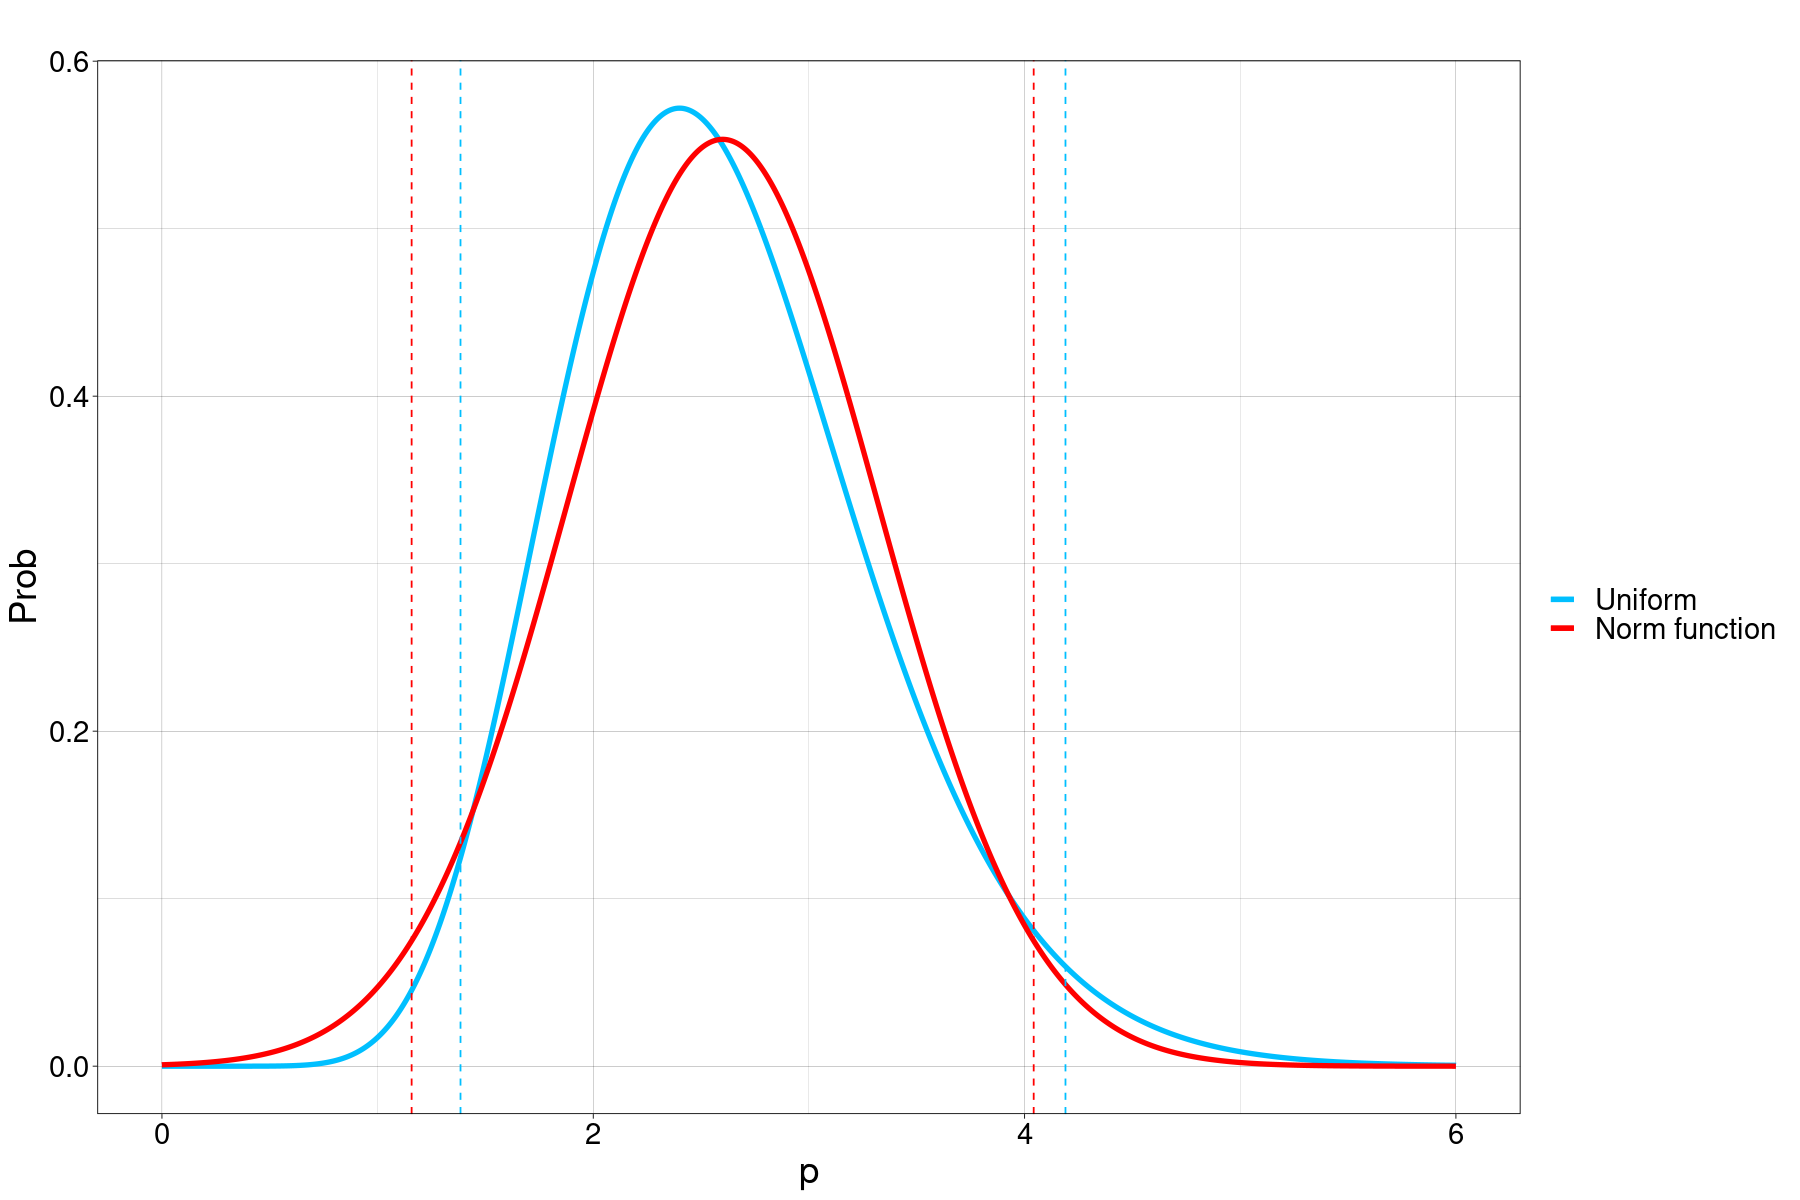

In [75]:
unif_plot <- ggplot() +
        geom_line(aes(x=p, y=norm_unif_posterior, color="Uniform"),lwd=1.5) + 
        geom_line(aes(x=p, y=unif_post_gauss, color="Norm function"),lwd=1.5) + 
        geom_vline(xintercept = unif_low , linetype="dashed", color="deepskyblue") +
        geom_vline(xintercept = unif_high, linetype="dashed", color="deepskyblue") +
        geom_vline(xintercept = low_unif_norm , linetype="dashed", color="red") +
        geom_vline(xintercept = high_unif_norm,linetype="dashed", color="red") +
        theme_linedraw() +
        scale_color_manual(name = "", values = c("Uniform" = "deepskyblue", "Norm function" = "red"))+
        labs(title=glue(""), x="p",y="Prob")+
        theme(text = element_text(size=22), plot.title = element_text( hjust = 0.5))
unif_plot

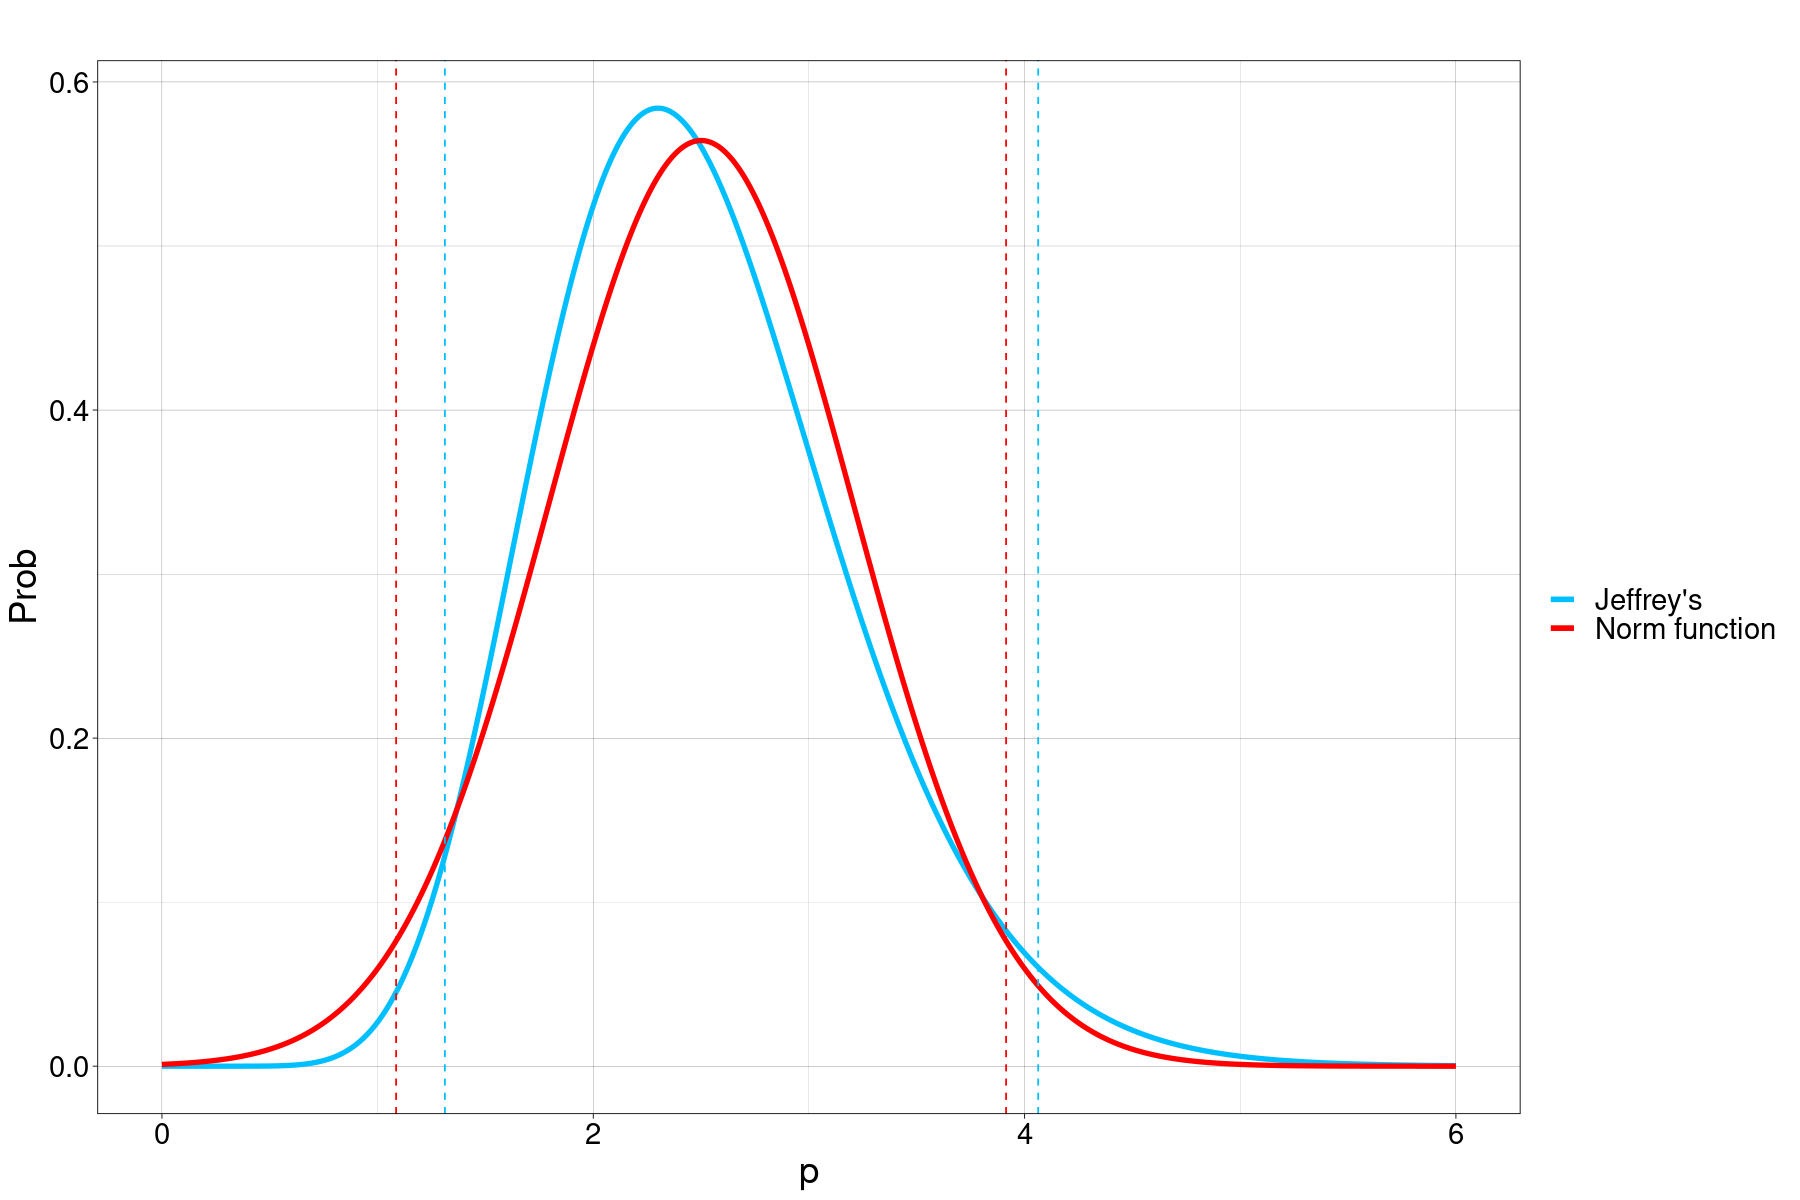

In [76]:
jeff_plot <- ggplot() +
        geom_line(aes(x=p, y=norm_jeff_posterior, color="Jeffrey's"),lwd=1.5) + 
        geom_line(aes(x=p, y=Jeff_post_gauss, color="Norm function"),lwd=1.5) + 
        geom_vline(xintercept = Jeff_low , linetype="dashed", color="deepskyblue") +
        geom_vline(xintercept = Jeff_high, linetype="dashed", color="deepskyblue") +
        geom_vline(xintercept = low_jeff_norm , linetype="dashed", color="red") +
        geom_vline(xintercept = high_jeff_norm,linetype="dashed", color="red") +
        theme_linedraw() +
        scale_color_manual(name = "", values = c("Jeffrey's" = "deepskyblue", "Norm function" = "red"))+
        labs(title=glue(""), x="p",y="Prob")+
        theme(text = element_text(size=22), plot.title = element_text( hjust = 0.5))
jeff_plot

## es2
### The lighthouse Problem
Both $\alpha$ and $\beta$ are unknown, so it means that there are two parameter to avaluate the probability. Assuming that they are independent parameters we have that:
\begin{equation}
P(\alpha, \beta | M) = P(\alpha | M) \times P(\beta | M)
\end{equation}
So the "total" prior can be written as the product of the two single priors, which we assumeuniform for both the parameter:
\begin{equation}
Prior =
\begin{cases}
\frac{1}{a - b} & x \in [a,b] \\
0 & otherwise
\end{cases}
\end{equation}
To evaluate the posterior we use, as always, the Bayses' theorem:
\begin{equation}
P(\alpha, \beta| {x_k},M) \propto P({x_k}|\alpha,\beta,M) \times P(\alpha|M) P(\beta|M)
\end{equation}
We set the true value: $\alpha^{*} = 2$, $\beta^{*} = 4$ used to generate data

In [77]:
# Questo è quello che va!!!

n_sample <- 500

x_min <- -4; x_max <- 4
y_min <- 0 ; y_max <- 8

alpha <- seq(x_min, x_max, length.out=n_sample+1)
beta  <- seq(y_min, y_max, length.out=n_sample+1)
h <- (x_max - x_min)/n_sample
k <- (y_max - y_min)/n_sample

alpha_true <- 2; beta_true  <- 4

In [78]:
#set of functions

data_generator <- function(n, a_true, b_true){
    thetas <- runif(n, min = -pi/2, max =pi/2)
    return(b_true * tan(thetas) + a_true)
}

# function for the logarithm of the prior 
log_prior <- function(alpha, beta){
    logPR <- log(dunif(alpha, min=x_min, max=x_max)) + log(dunif(beta, min=y_min, max=y_max))
    return(logPR)
}

# function for the logarithm of the likelihood
log_likelihood <- function(data, alpha, beta) {
    logL <- rep(0, length(alpha))
    for (x in data) {
        logL <- logL + log((beta/pi)/(beta^2+(x-alpha)^2))
    }
    return(logL)
}
# function for the logarithm of the posterior
log_posterior <- function(alpha, beta, data){
    logPT <- log_likelihood(data, alpha, beta) + log_prior(alpha, beta)
    return(logPT)
}


To show the results of the posterior we first show a 3D plot where alpha values are in x axis and beta ones are in the y axis and on the z axis there is the posterior function.\
The plots show the evolution of the posterior with respect to the increasing number of data

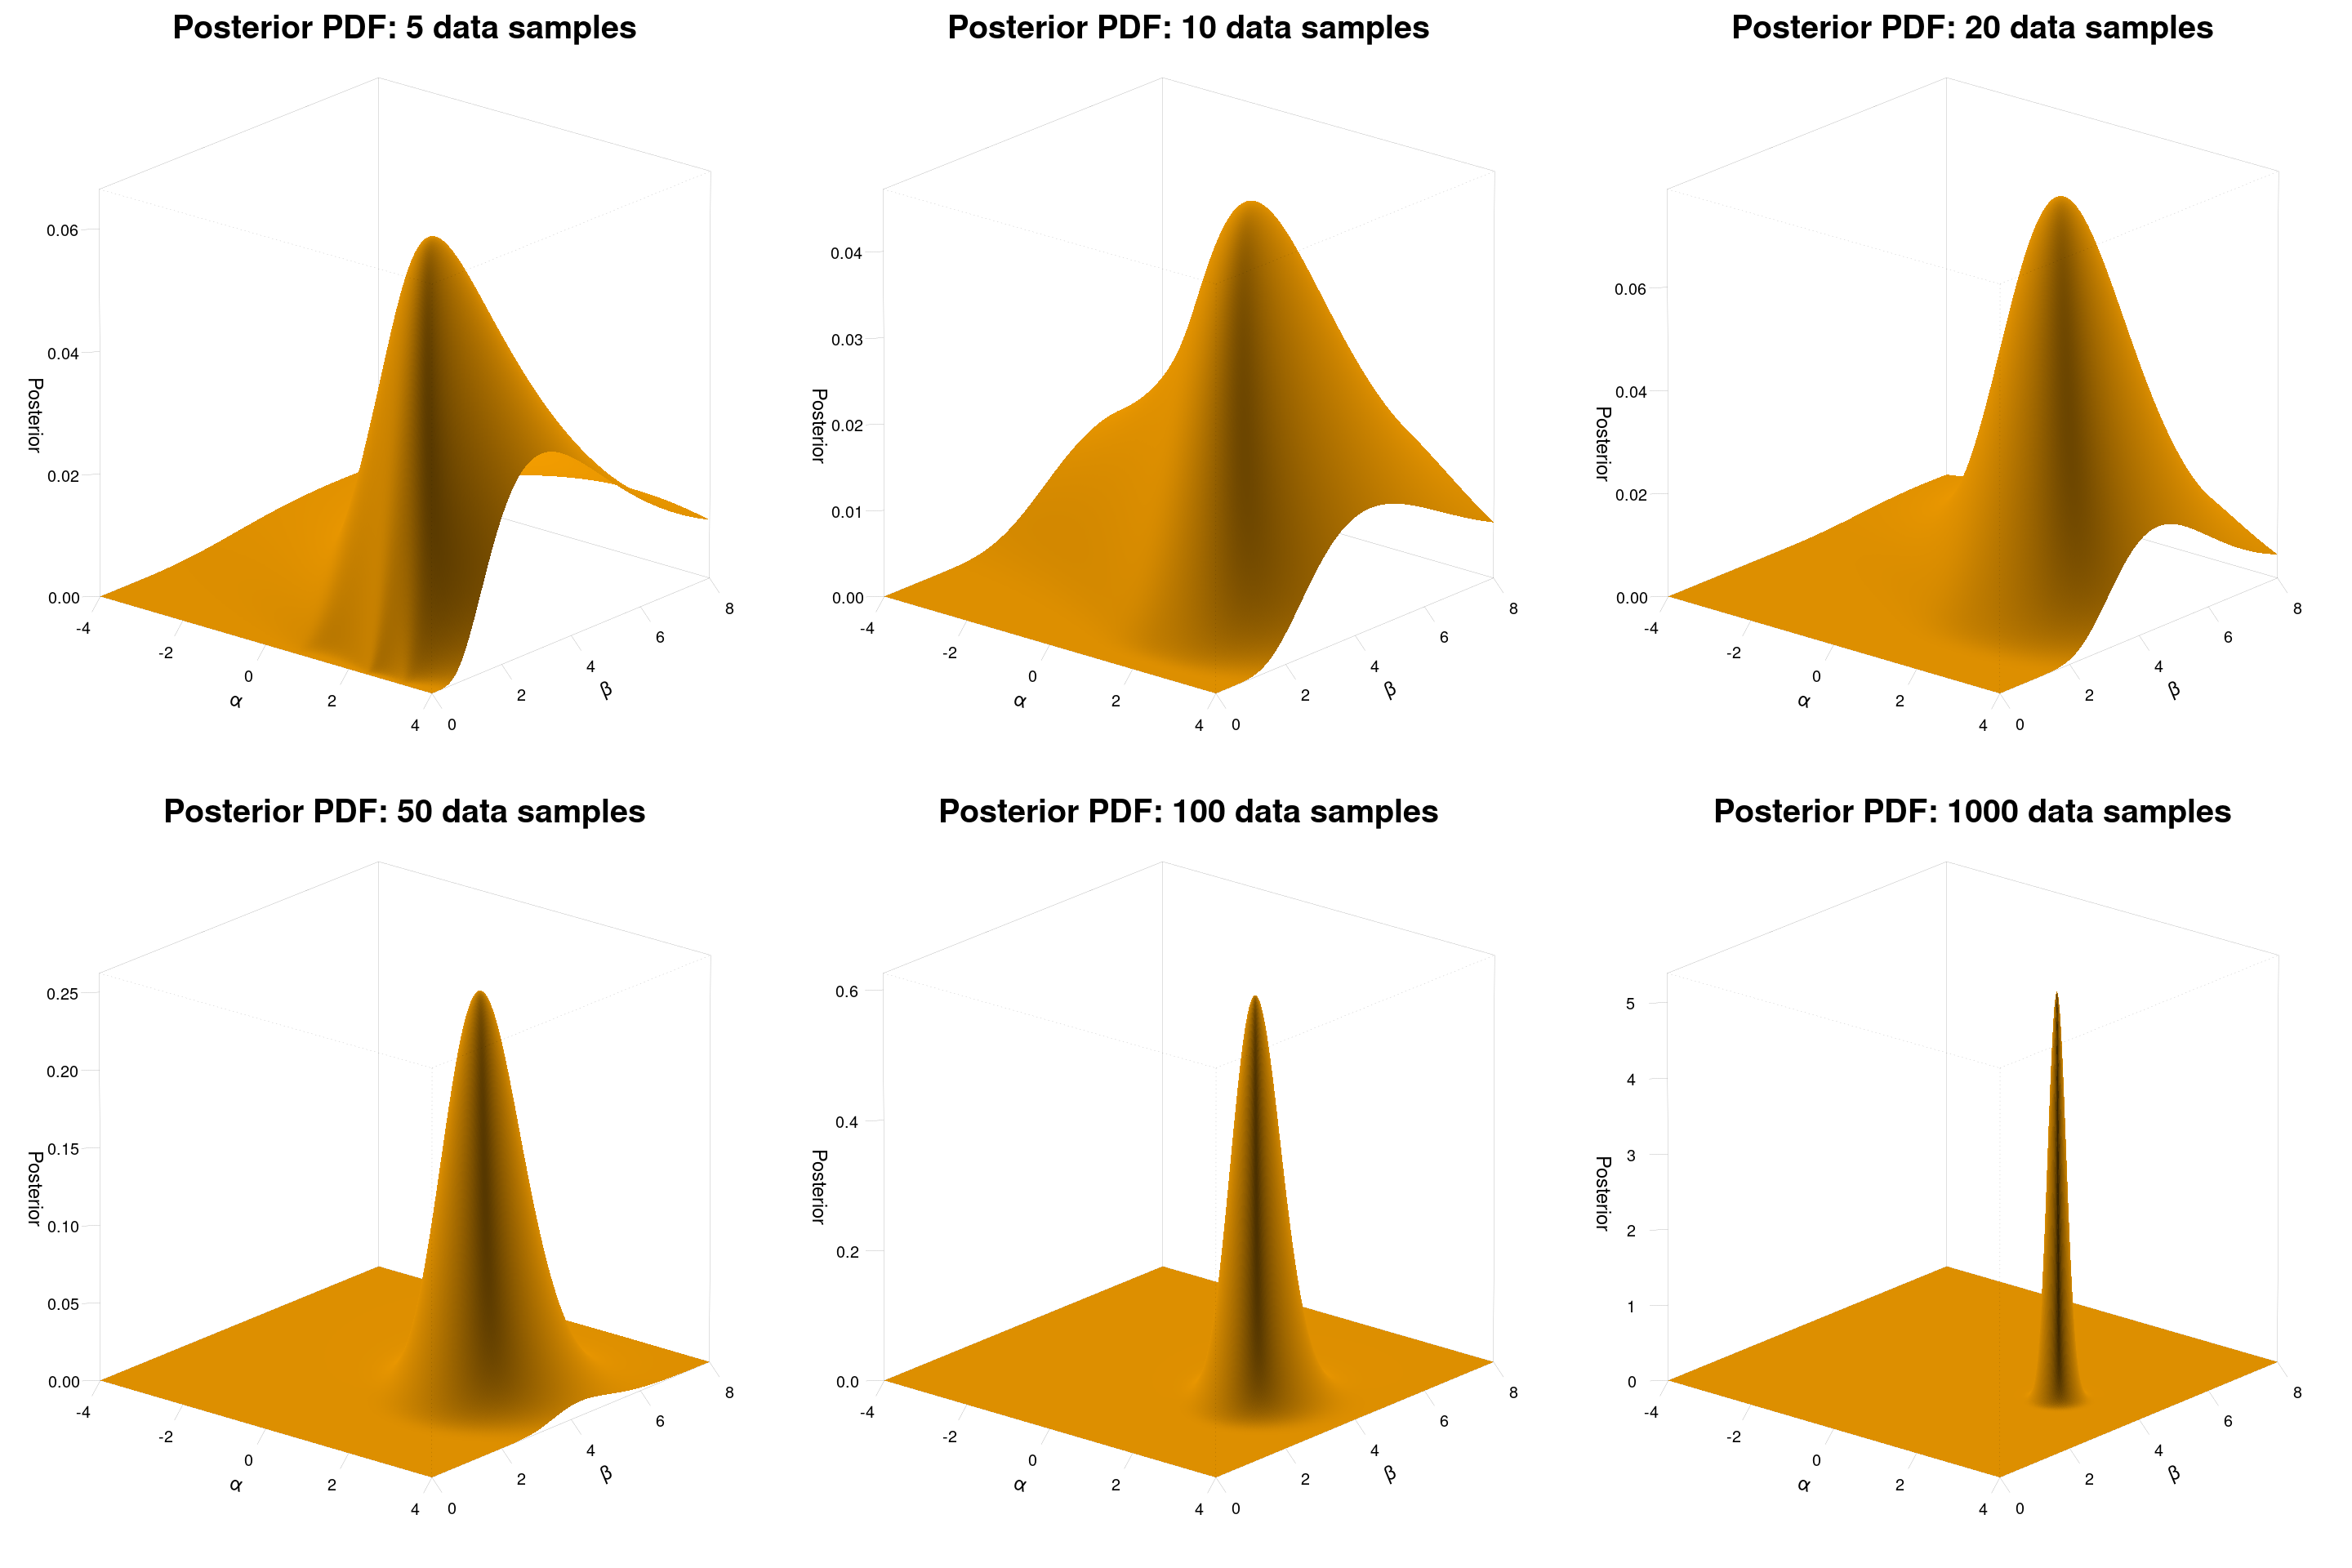

In [79]:
n <- c(5,10,20,50,100,1000)
options(repr.plot.width=24, repr.plot.height=16)
par(mfrow=c(2, 3))

data <- data_generator(max(n), alpha_true, beta_true)

for (i in n){
    dat <- data[1:i]
    l_post <- outer(alpha, beta, purrr::partial(log_posterior, data=dat))
    l_post <- l_post - max(l_post) #set maximum to zero
    norm_post <- exp(l_post)/(h*k*sum(exp(l_post)))
    # plotting the posterior in 3D
    persp(alpha, beta , norm_post,
          xlab='α',
          ylab='β',
          zlab='Posterior', 
          main=sprintf("Posterior PDF: %d data samples",i),
          lwd=0.1, ticktype="detailed", col="Orange",
          cex.lab=1.8, cex.axis=1.5, cex.main=3,
          xlim=c(x_min,x_max),
          ylim=c(y_min,y_max),
          theta=40, phi=20, d=100.0, shade=0.2, border = NA)
}

From these plots we can see that in the last picture (1000 data samples) the posterior reach the maximum near the value of $\alpha \simeq 2$ e $\beta \simeq 4$. Sice it's not clear enough we can show a series of plots in which we visualize only the $\alpha$ or $\beta$ axis and their posterior probability value (2D plot), to highlight the single independent posteriors.

To show the evolution of the posterior only for one parameter, we have to integrate over the other parameter. So we have to sum the poterior matrix values for the given parameter that want.\
for example: $P(\alpha | M ) = \int P(\alpha, \beta | M) d\beta $\
Since the priors are independent, this procedure is like projecting along the $\alpha$ or $\beta$ axis. "Marginalization"

In this plots the orange lines are the true value of alpha and beta, while the dashed lines are the alpha and beta value that correspond to the maximum of the posterior.

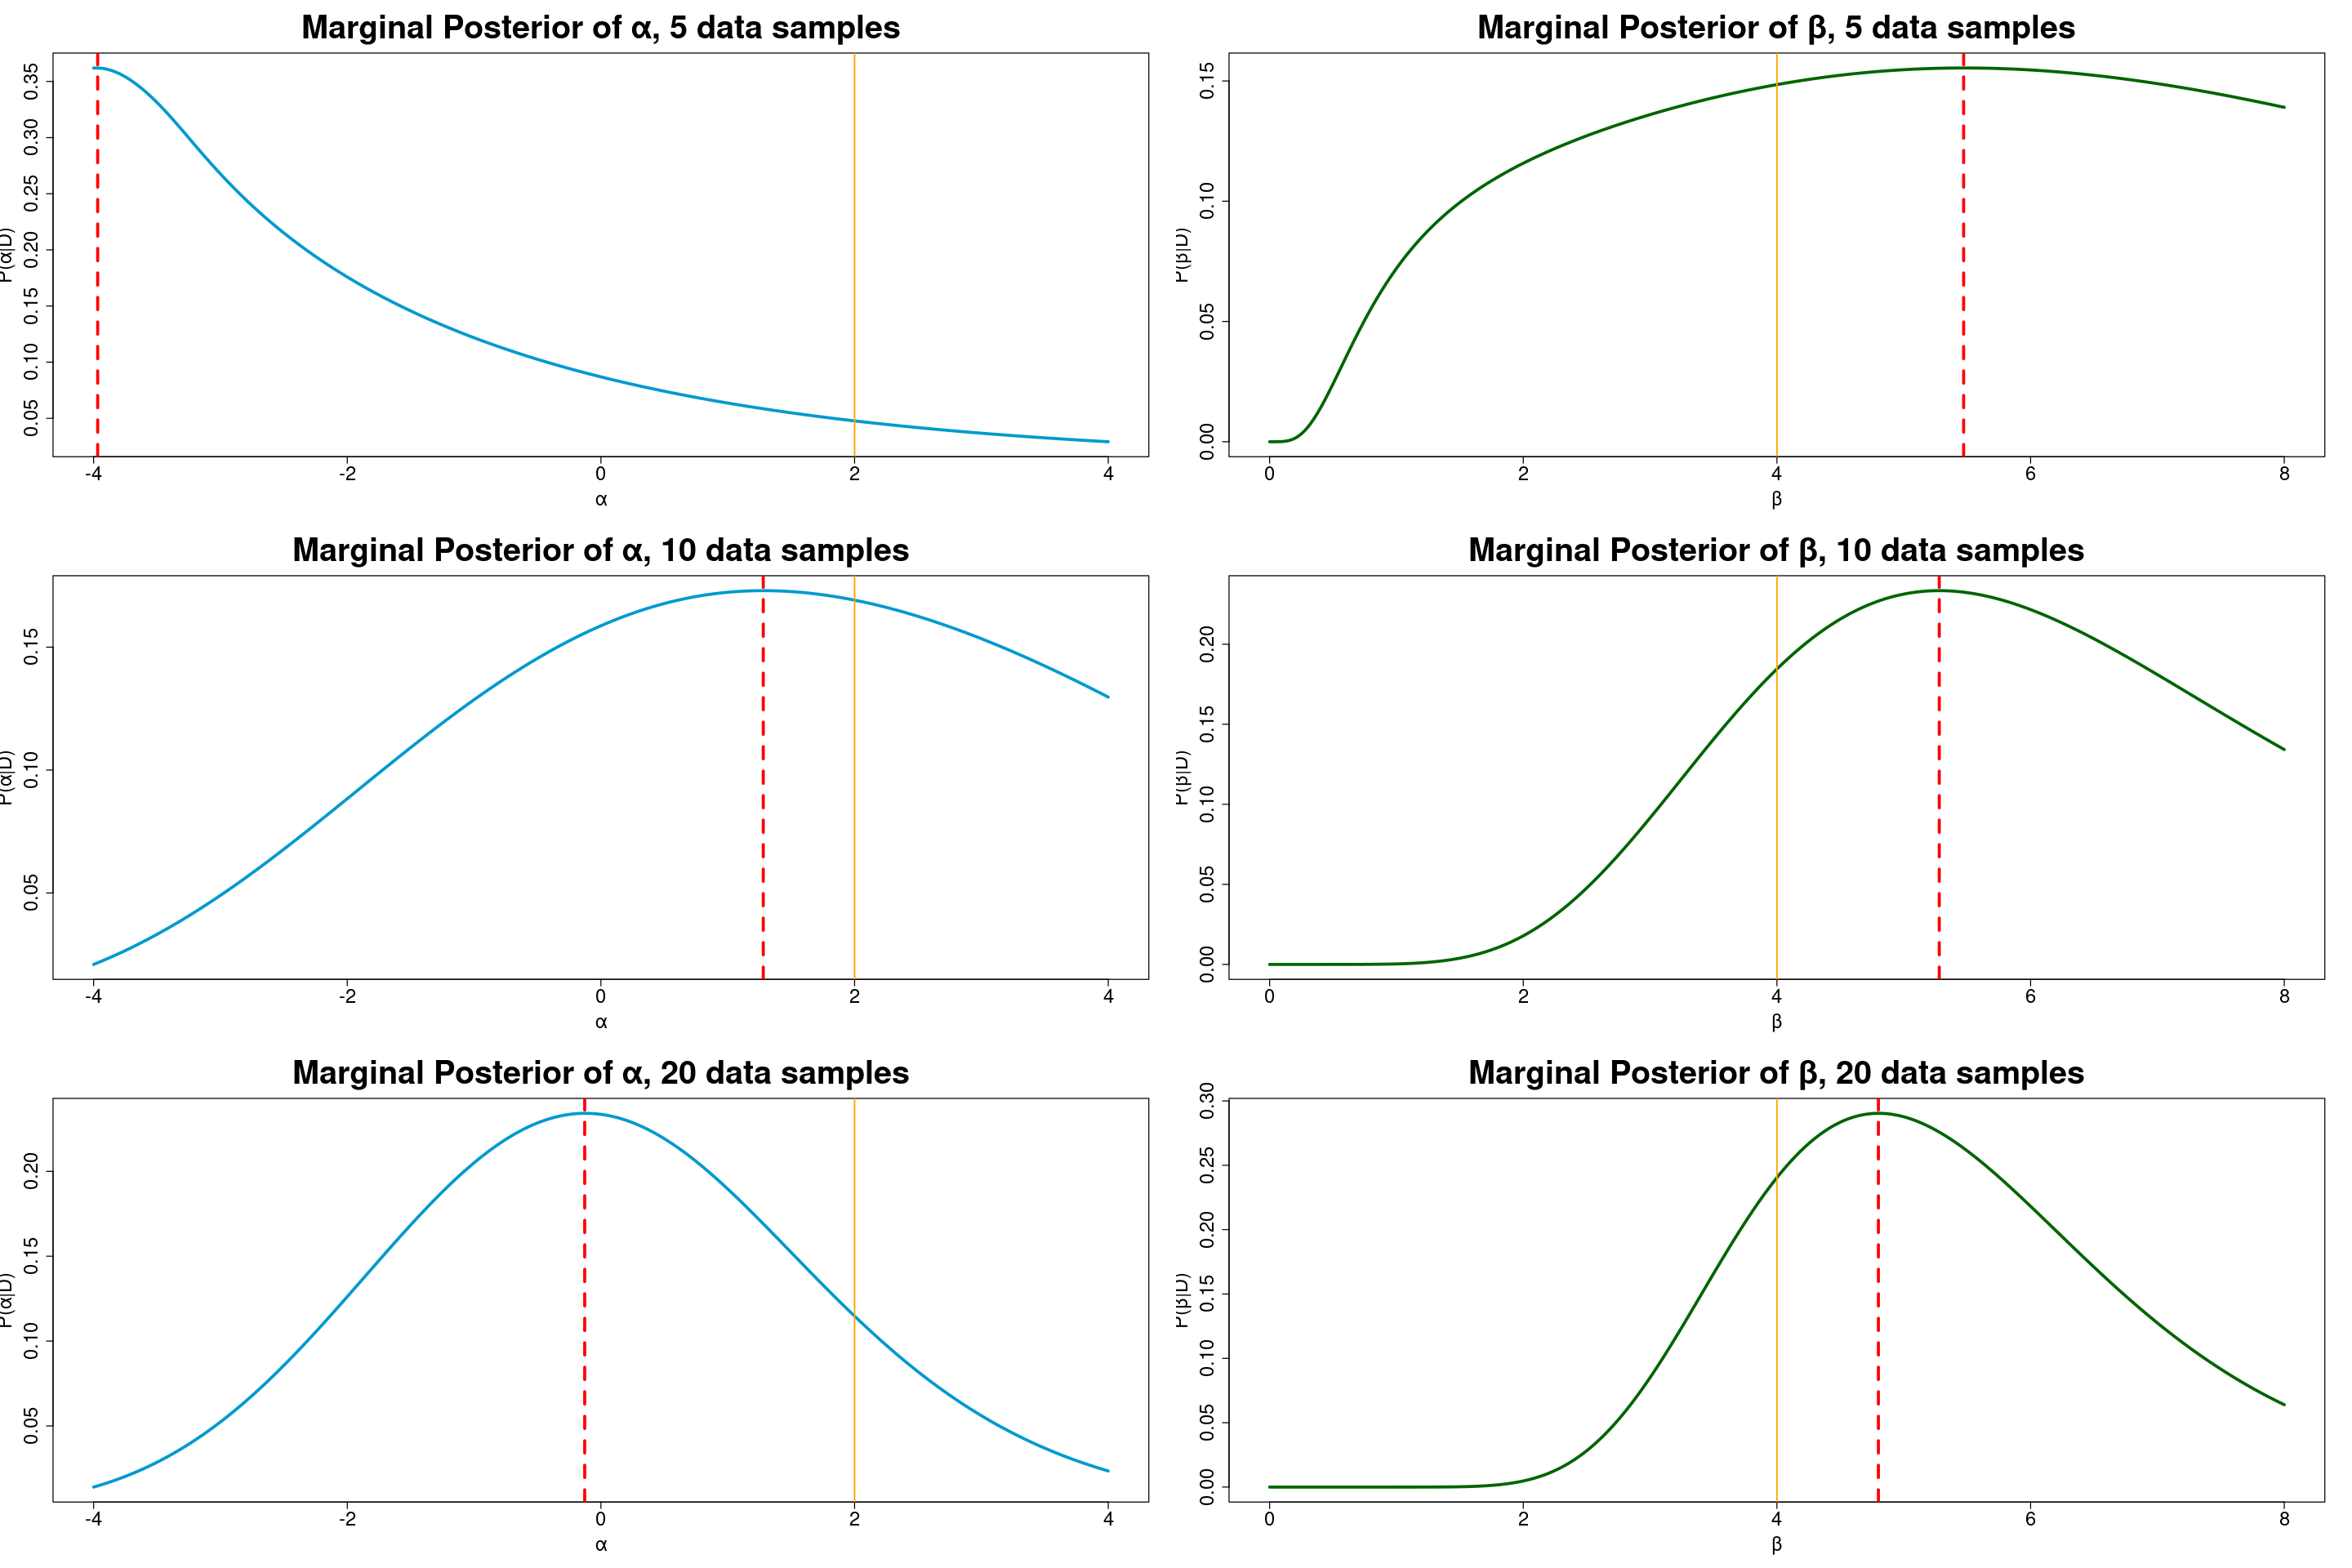

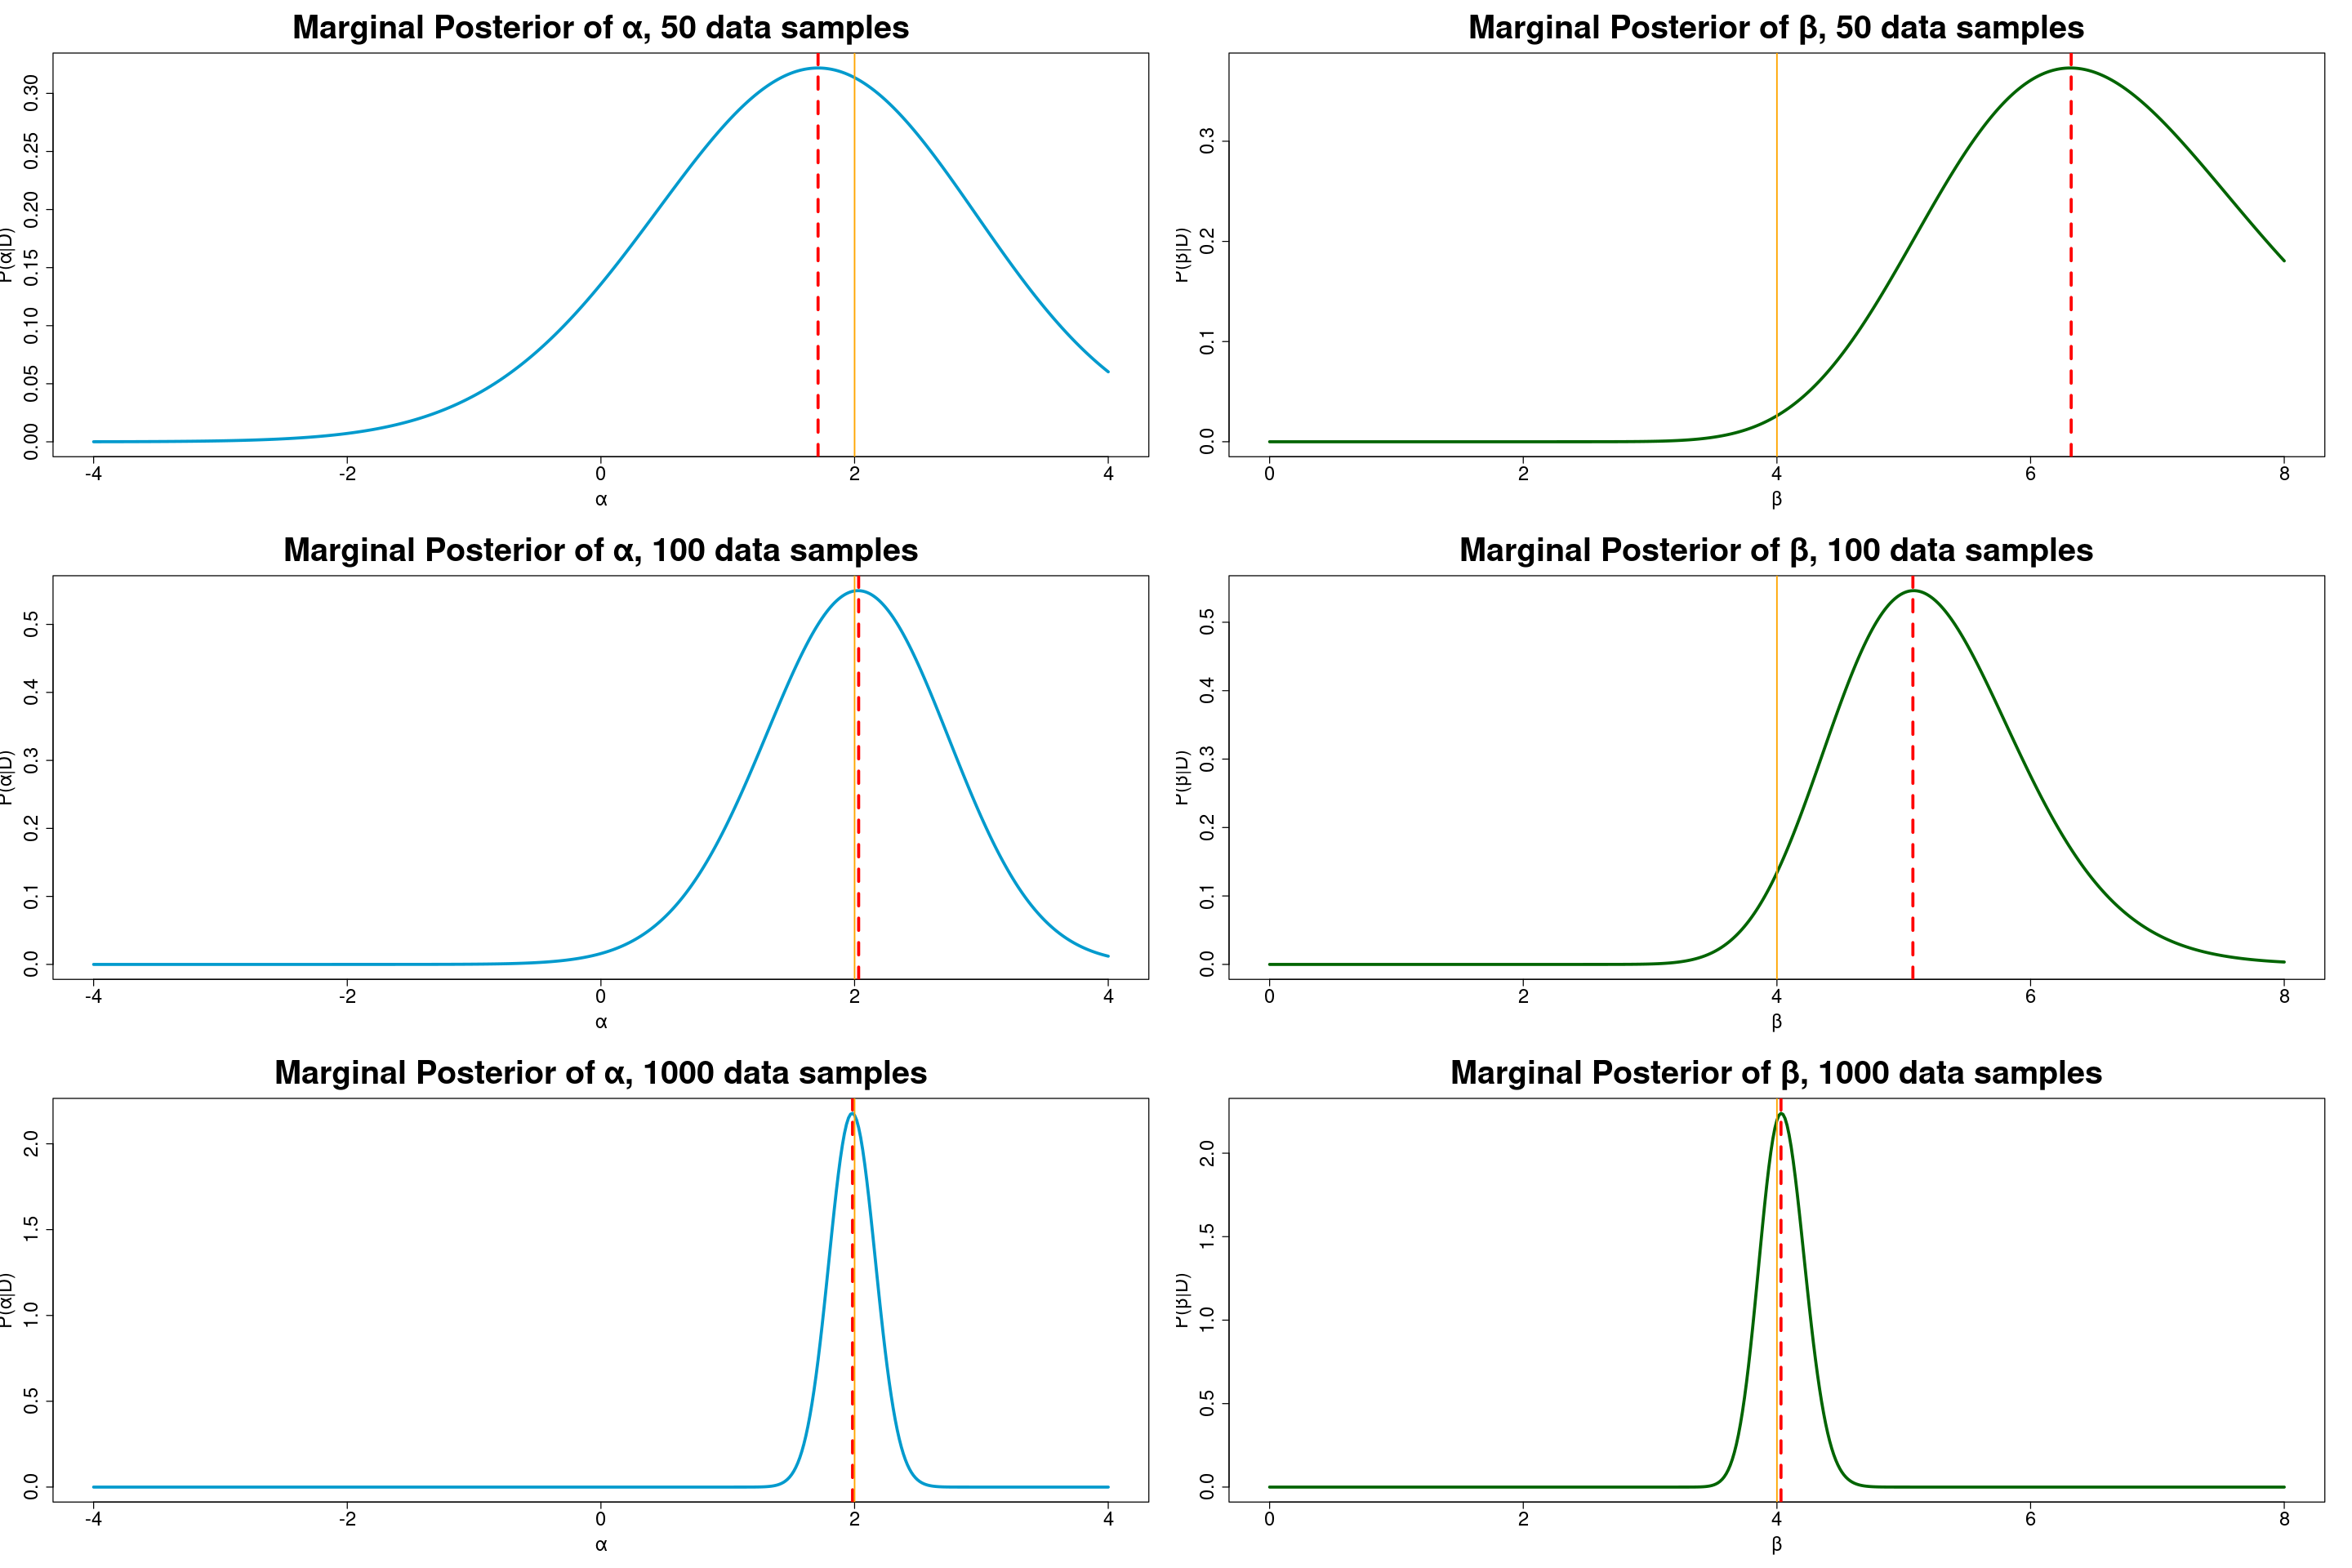

In [80]:
options(repr.plot.width=24, repr.plot.height=16)
par(mfrow=c(3, 2))

data <- data_generator(max(n), alpha_true, beta_true)

for (i in n){
    dat <- data[1:i]
    l_post <- outer(alpha, beta, purrr::partial(log_posterior, data=dat))
    l_post <- l_post - max(l_post) #set maximum to zero
    norm_post <- exp(l_post)/(h*k*sum(exp(l_post)))

    pna <- apply(norm_post, 1, sum)
    pnb <- apply(norm_post, 2, sum)

    post_norm_a <- pna / (h * sum(pna))
    post_norm_b <- pnb / (k * sum(pnb))
    find_max = function(p, pd){
        return(p[which(pd>=max(pd)[1])])
    }
    #selectin alpha and beta which correspond to the maximum of the pfd
    max_a <- alpha[which(post_norm_a == max(post_norm_a)[1])]
    max_b <- beta[which(post_norm_b == max(post_norm_b)[1])]

    plot(alpha, post_norm_a, main = sprintf("Marginal Posterior of α, %d data samples", i),
        col="deepskyblue3", xlab = 'α', ylab = 'P(α|D)', cex.lab=1.8, cex.axis=1.8, cex.main=3, type='l', lwd=3)
    abline(v = max_a, col="red", lwd=3, lty=2)
    abline(v = alpha_true, col="orange", lwd=1.5)
    
    plot(beta, post_norm_b, main = sprintf("Marginal Posterior of β, %d data samples", i),
        col="darkgreen", xlab = 'β', ylab = 'P(β|D)', cex.lab=1.8, cex.axis=1.8, cex.main=3, type='l', lwd=3)
    abline(v = max_b, col="red", lwd=3, lty=2)
    abline(v = beta_true, col="orange", lwd=1.5)

}

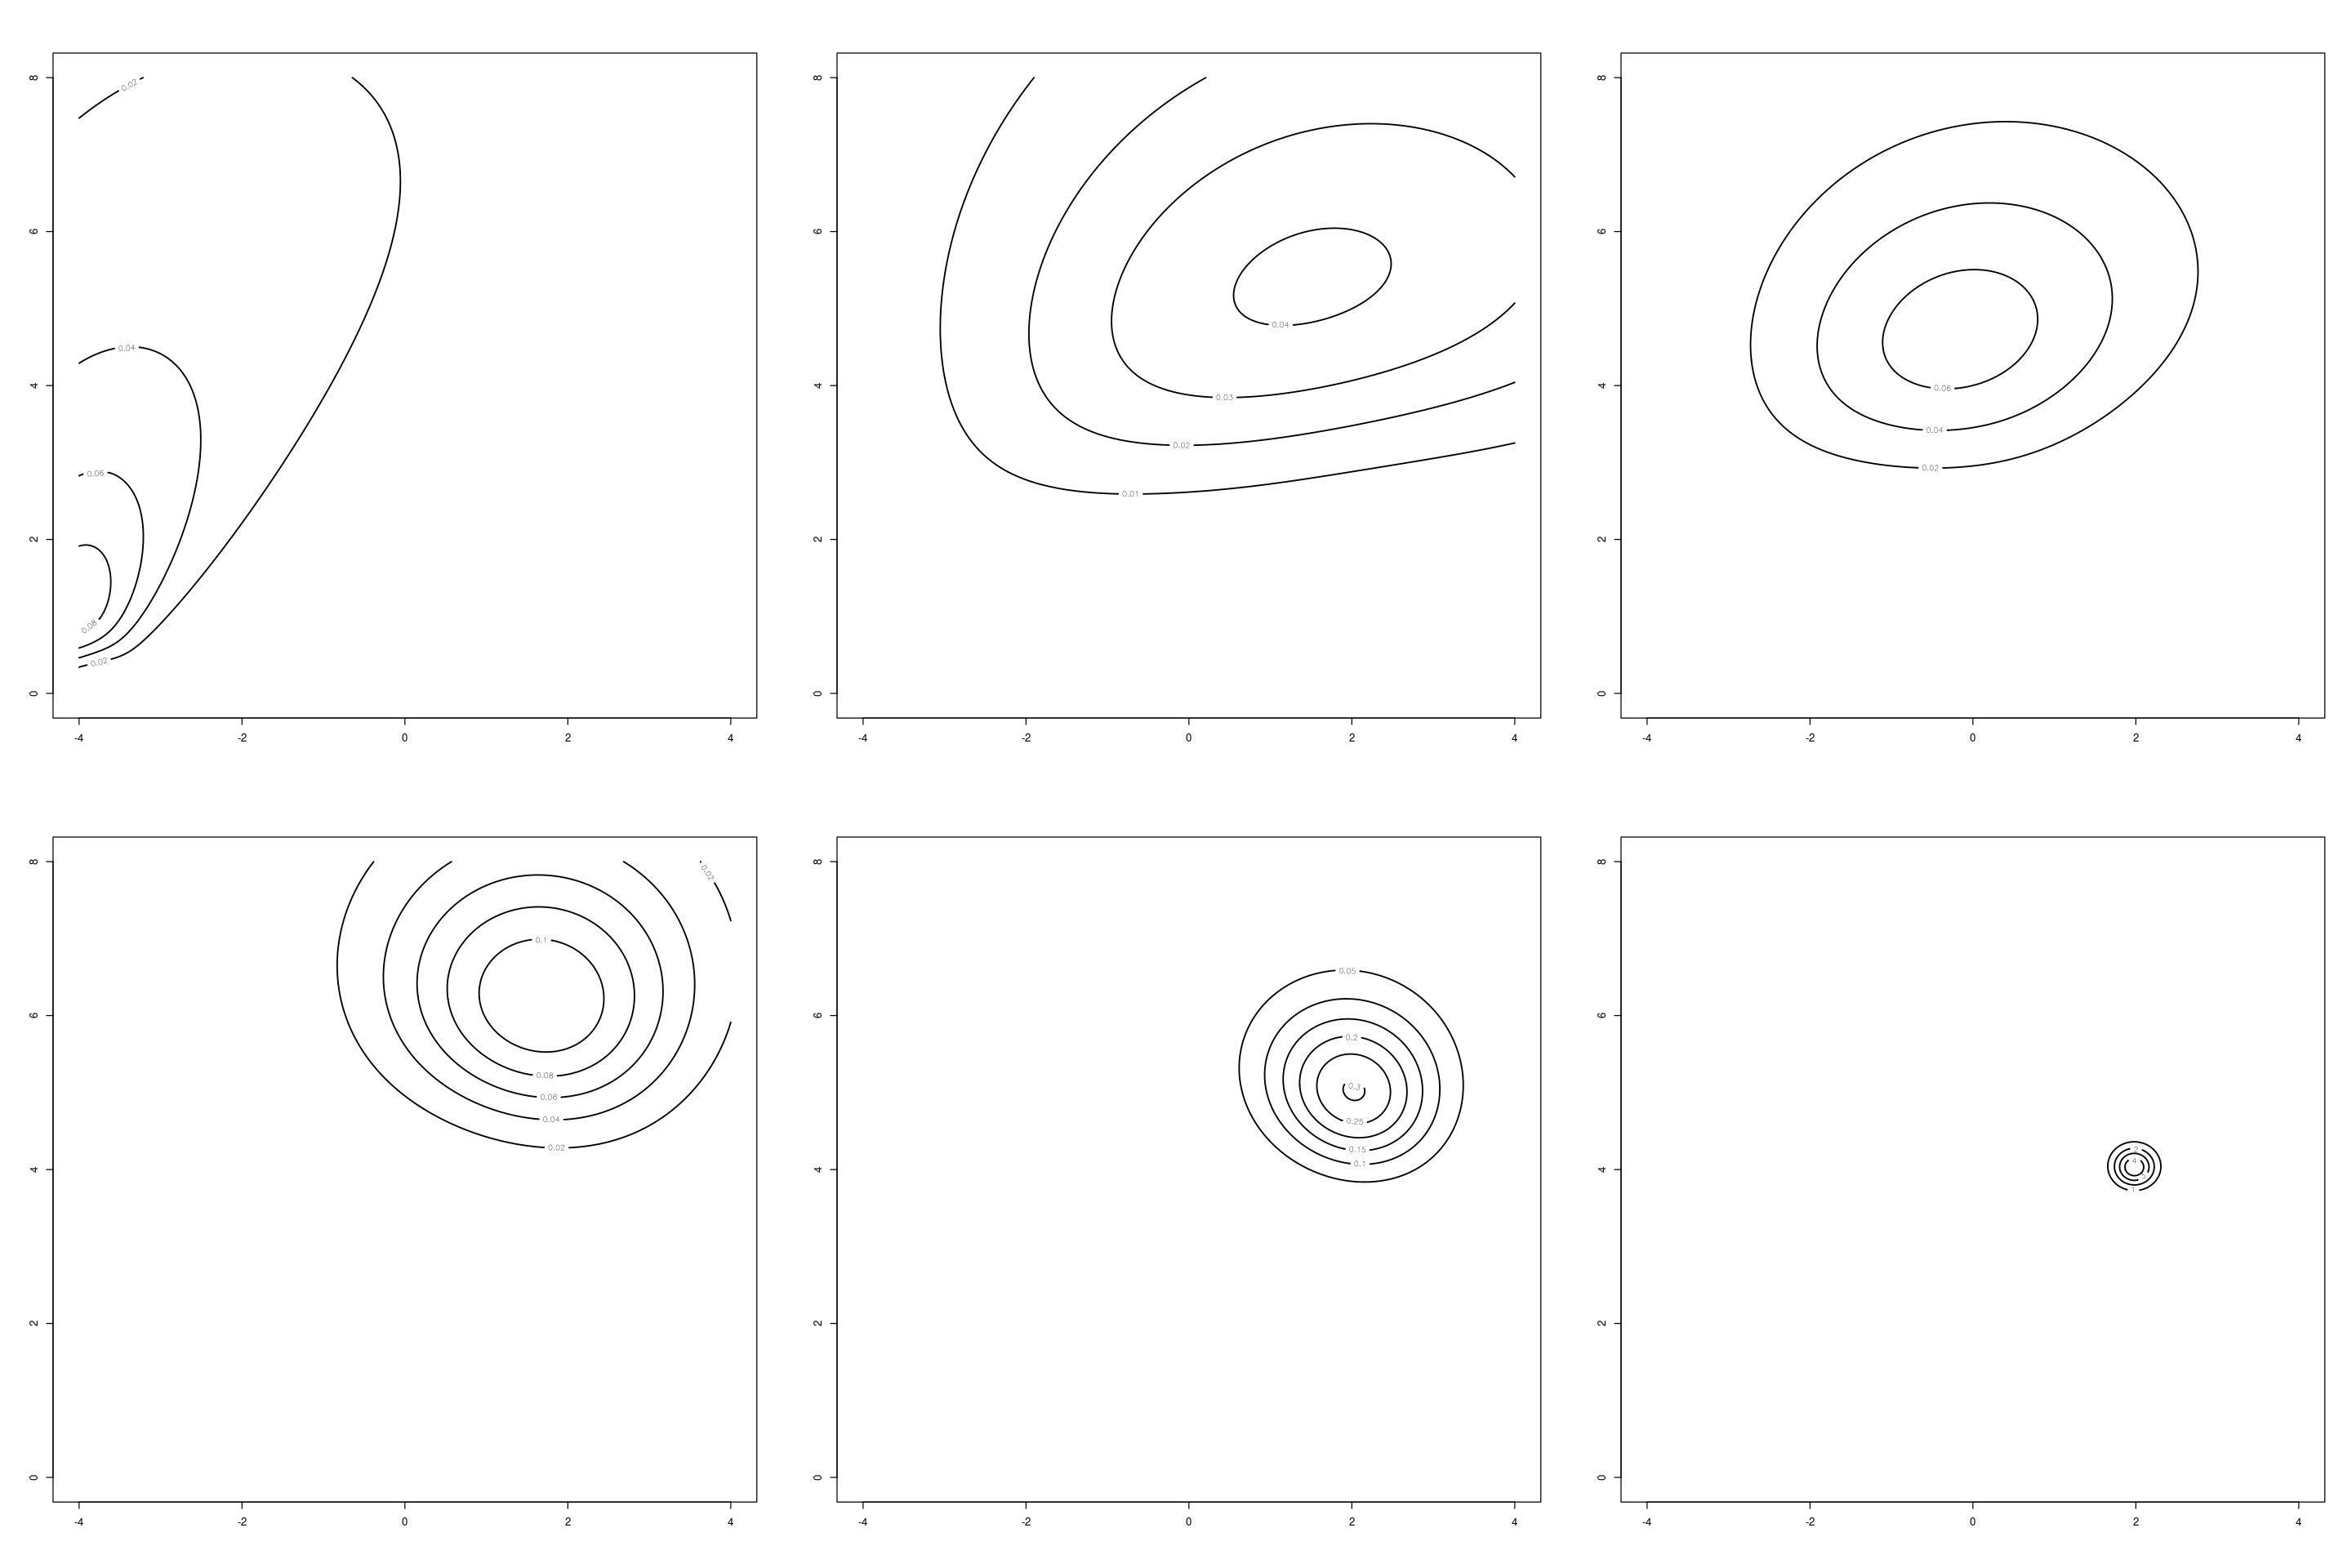

In [81]:
par(mfrow=c(2, 3))

for (i in n){
    dat <- data[1:i]
    l_post <- outer(alpha, beta, purrr::partial(log_posterior, data=dat))
    l_post <- l_post - max(l_post)
    norm_post <- exp(l_post)/(h*k*sum(exp(l_post)))
    
    post_alpha <- apply(norm_post, 1, sum)
    post_beta  <- apply(norm_post, 2, sum)

    norm_post_alpha <- post_alpha / (h*sum(post_alpha))
    norm_post_beta  <- post_beta  / (k*sum(post_beta))

    max_p_alpha <- max(norm_post_alpha)
    max_p_beta  <- max(norm_post_beta)

    #PLOT
    contour(alpha, beta, norm_post,
            nlevels = 5,
            labcex = 0.5,
            lwd = 1.5)
}

## es3

In [82]:
signal <- function(x, a, b, x0, w, t) {
    return(t * (a* exp(-(x-x0)^2 / (2*w^2)) + b))
}

x0 <- 0; delta_t <- 5; w <- 1
A_true <- 2; B_true <- 1

res <- c(0.05, 0.1, 0.25, 1, 2, 3)

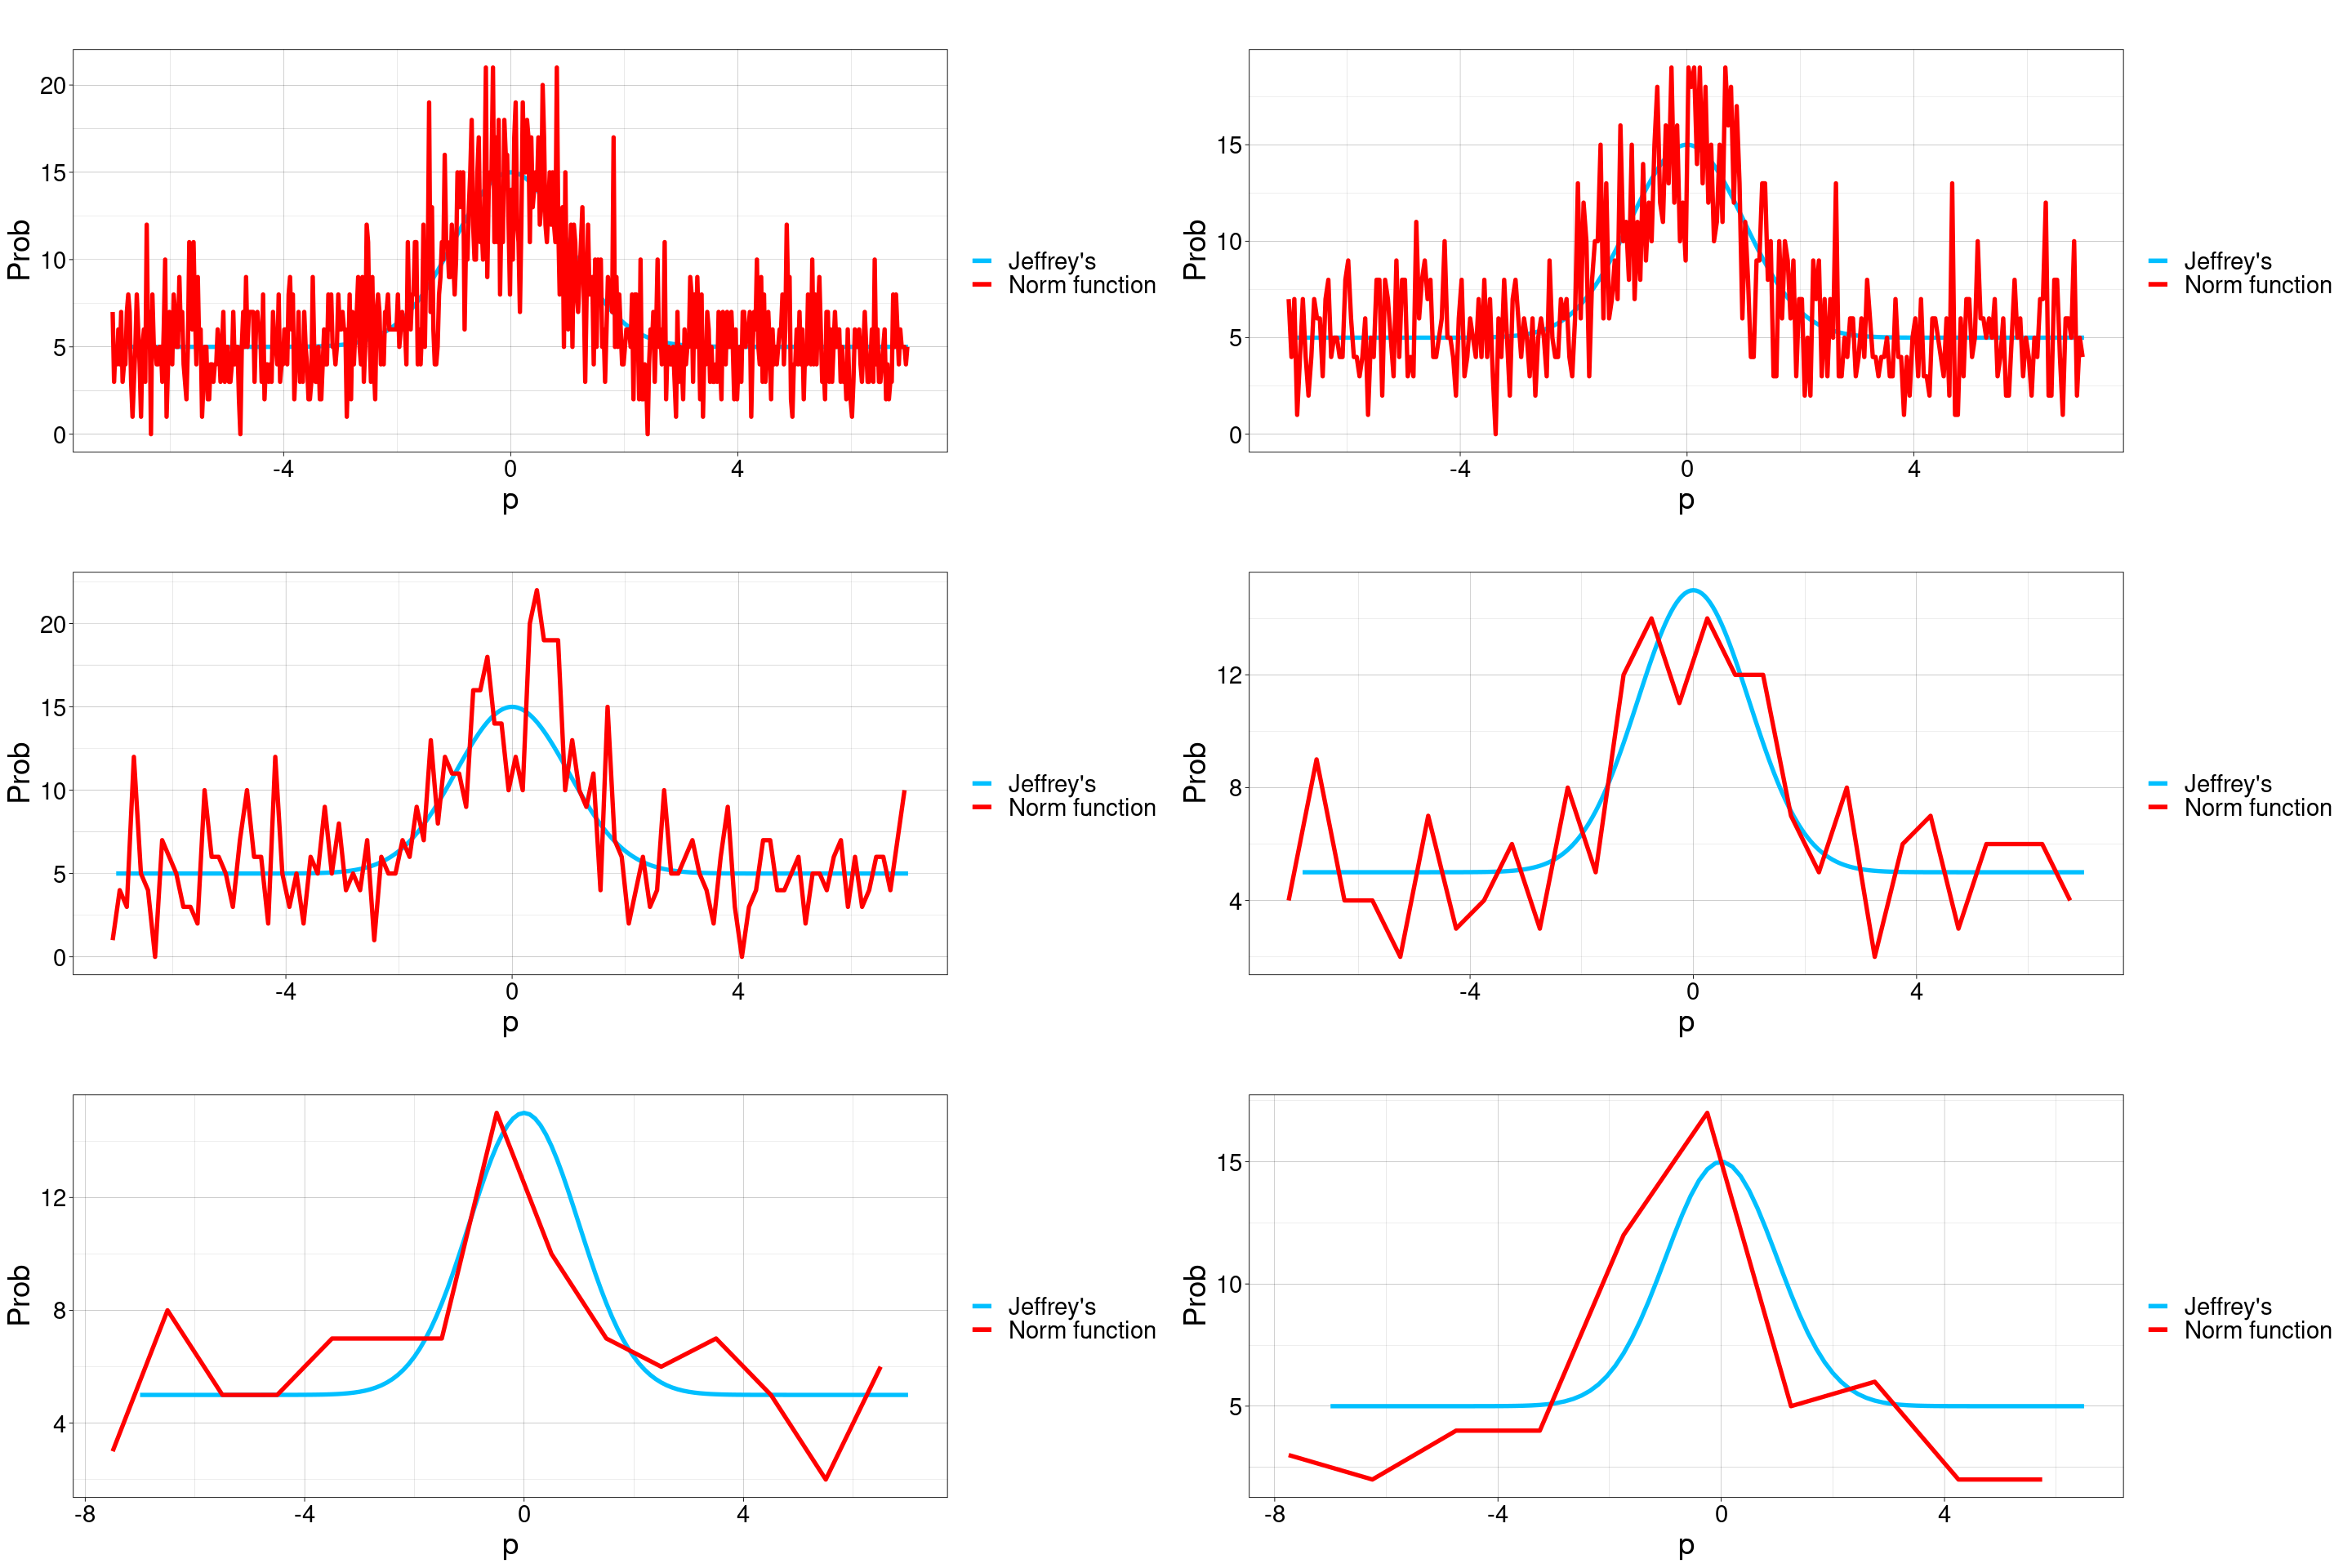

In [83]:
options(repr.plot.width=24, repr.plot.height=16)

plots <- list()
for (i in 1:length(res)){
    xdat <- seq(from= -7*w, to= 7*w, by= 0.5*res[i])
    signal_true <- signal(xdat, A_true, B_true, x0, w, delta_t)
    ddat <- rpois(length(signal_true), signal_true)
    
    xx <- seq(min(xdat), max(xdat), 0.05*res[i])
    yy <- signal(xx, A_true , B_true , x0, w, delta_t)

    xdat_off <- xdat - 0.25*res[i]

    plot <- ggplot() + 
        geom_line(aes(x=xx, y=yy, color="Jeffrey's"),lwd=1.5) + 
        geom_line(aes(x=xdat_off, y=ddat, color="Norm function"),lwd=1.5) + 
        theme_linedraw() +
        scale_color_manual(name = "", values = c("Jeffrey's" = "deepskyblue", "Norm function" = "red"))+
        labs(title=glue(""), x="p",y="Prob")+
        theme(text = element_text(size=22), plot.title = element_text( hjust = 0.5))
    
    plots[[i]] = ggplotGrob(plot)
      
}
grid.arrange(grobs=plots, ncol=, nrow=)


In [84]:
alim <- c(0.0, 4.0); blim <- c(0.5, 1.5)
nsample <- 100
unigrid <- seq( 1/(2*nsample), 1-1/(2*nsample), by=1/nsample)
delta_a <- diff(alim)/nsample; delta_b <- diff(blim)/nsample

a <- alim[1] + diff(alim)*unigrid
b <- blim[1] + diff(blim)*unigrid

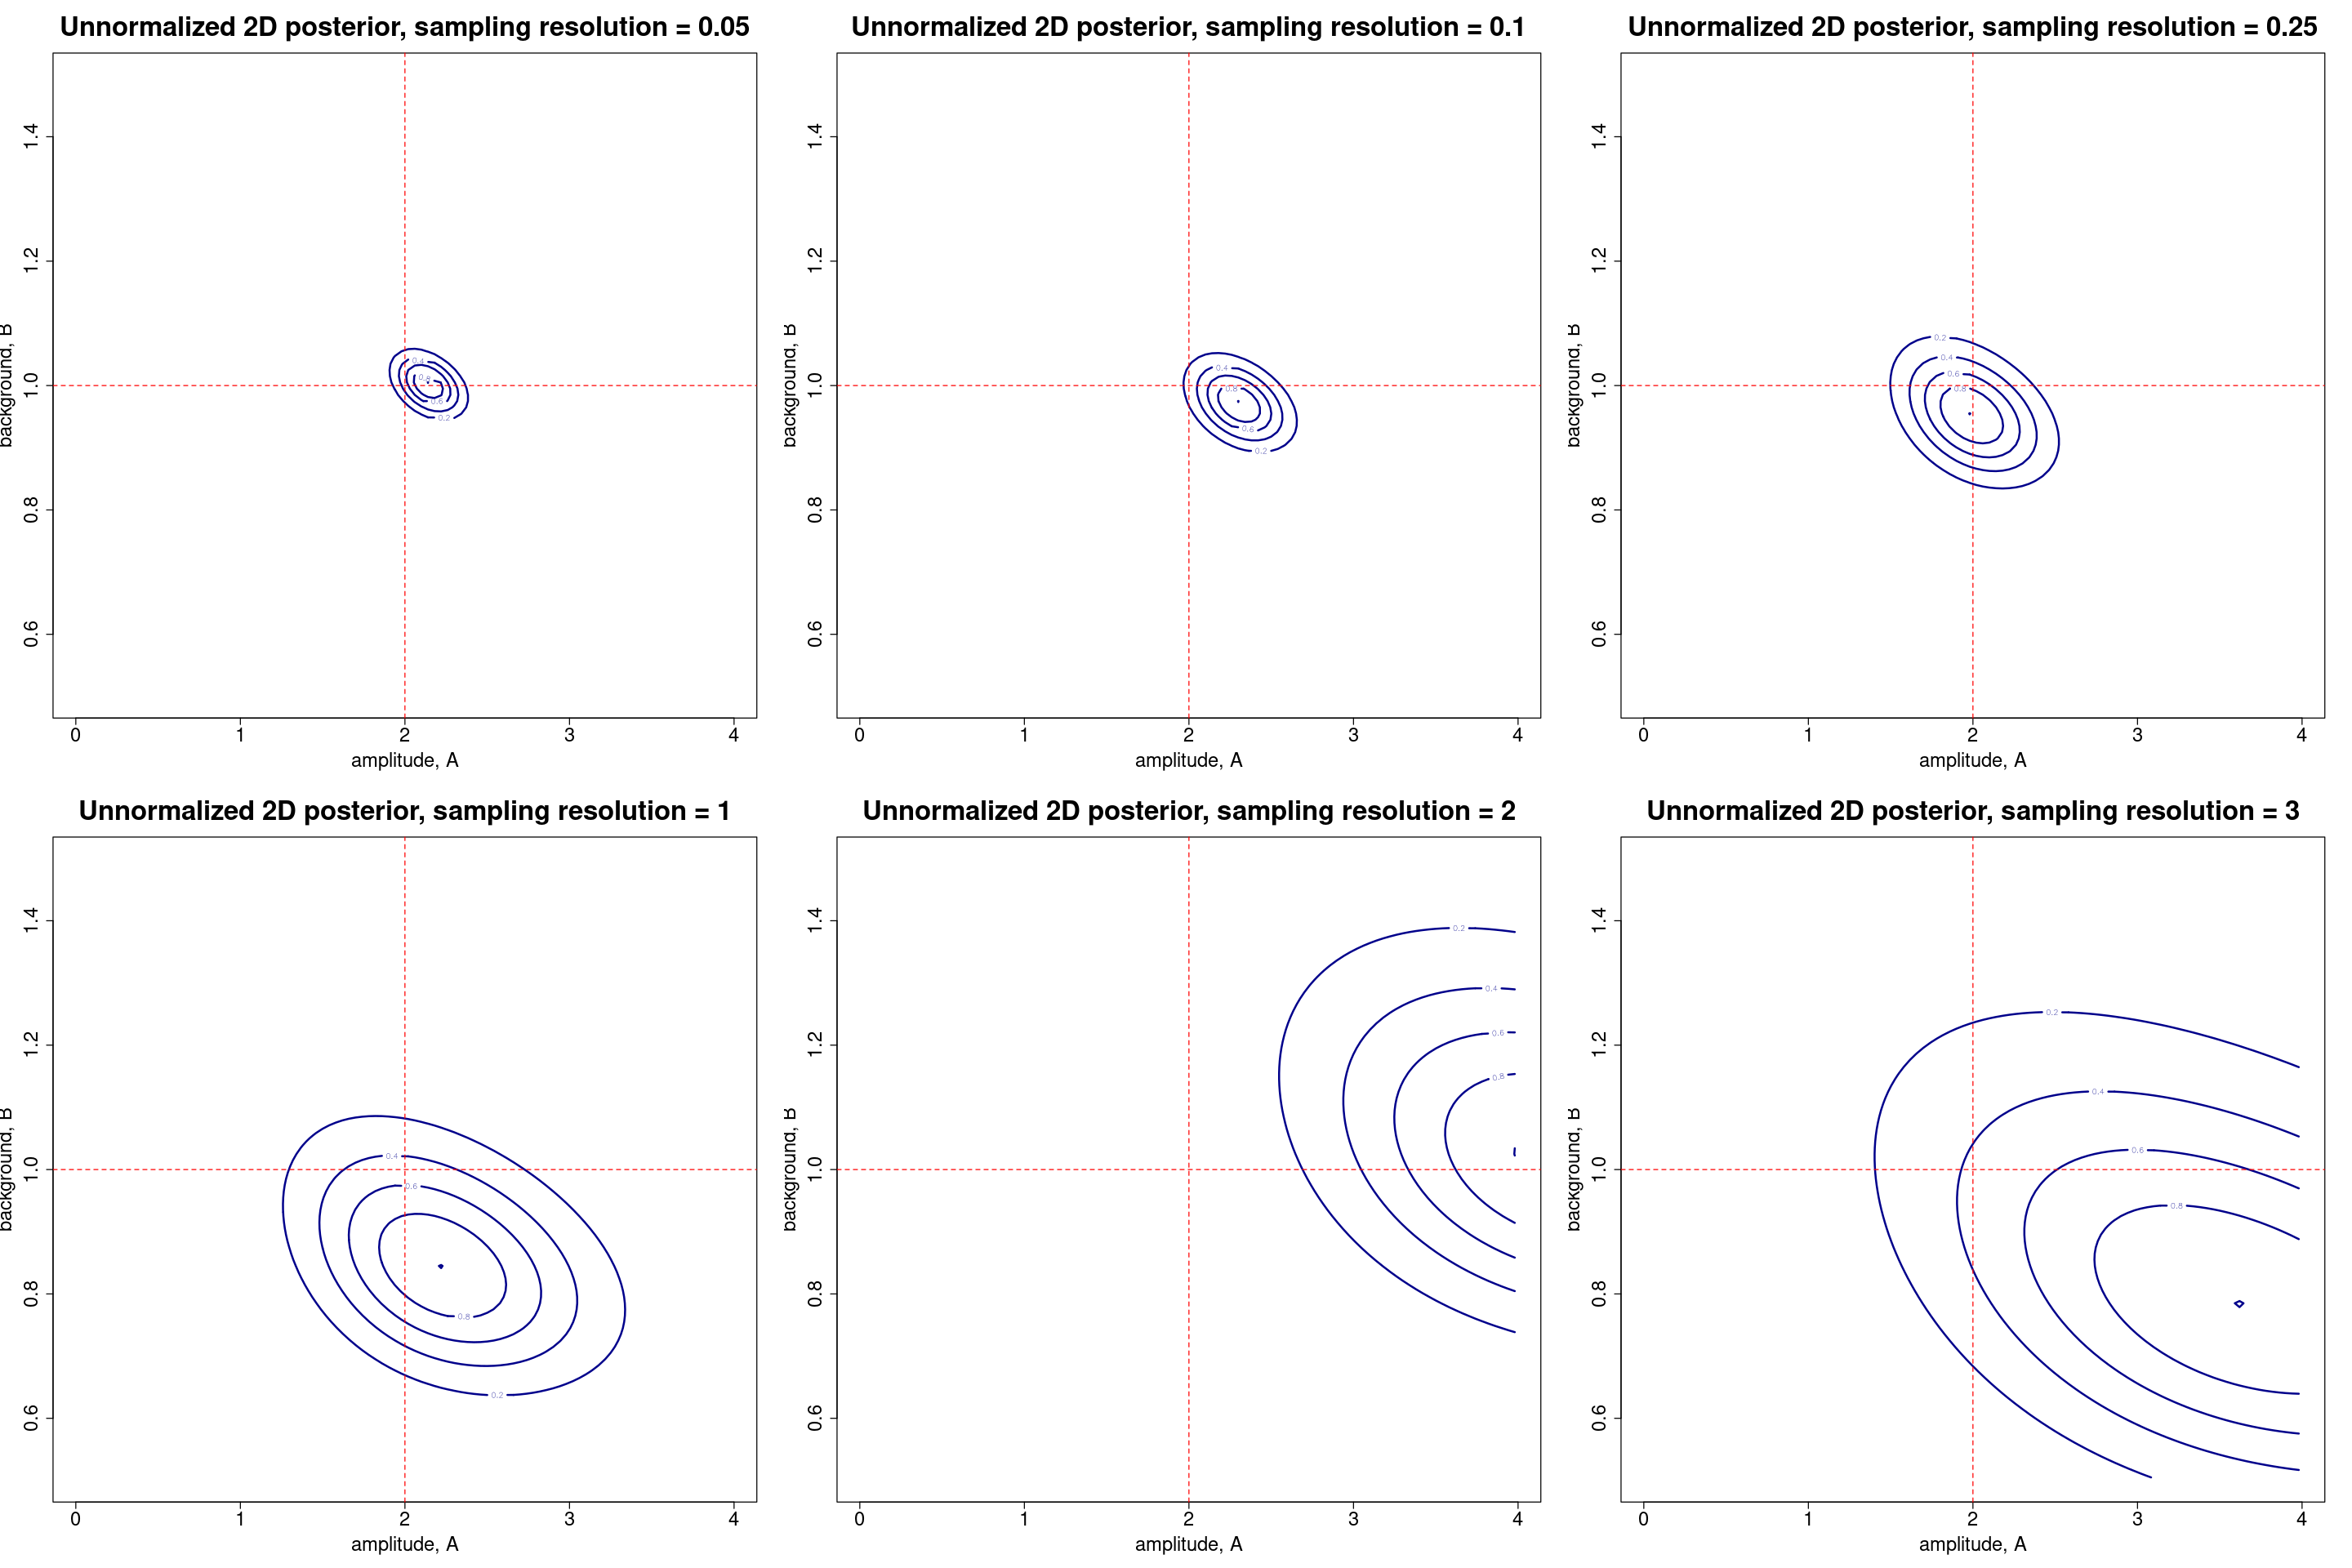

In [85]:
# since the prior is constant when both a and b are positive and zero otherwise:
# Log posterior
log_post <- function(d, x, a, b, x0, w, t) {
    if(a<0 || b <0) {return(-Inf)}
    sum(dpois(d, lambda=signal(x, a, b, x0, w, t), log=TRUE))
}

# Compute log unnormalized posterior , z = ln Pˆ*(a,b|D), on a regular grid

options(repr.plot.width=24, repr.plot.height=16)
par(mfrow=c(2, 3))
for (i in res){
    set.seed(2022461)
    xdat = seq(from=-7*w, to=7*w, by=i*w)
    s_true = signal(xdat, A_true , B_true , x0, w, delta_t)
    ddat = rpois(length(s_true), s_true)
    z = matrix(data=NA, nrow=length(a), ncol=length(b))
    for(j in 1:length(a)) {
        for(k in 1:length(b)) {
            z[j,k] = log_post(ddat, xdat, a[j], b[k], x0, w, delta_t)
        }
    }
    z = z - max(z) # set maximum to zero
    
    # Plot unnormalized 2D posterior as contours.
    
    contour(a, b, exp(z), nlevels = 5, labcex = 0.5, lwd = 2, xlab="amplitude, A", ylab="background, B",
           main = sprintf('Unnormalized 2D posterior, sampling resolution = %g', i), col = 'darkblue',
           cex.lab=1.8, cex.axis=1.8, cex.main=2.5)
    abline(v=2,h=1,col="red", lty=2)
    }



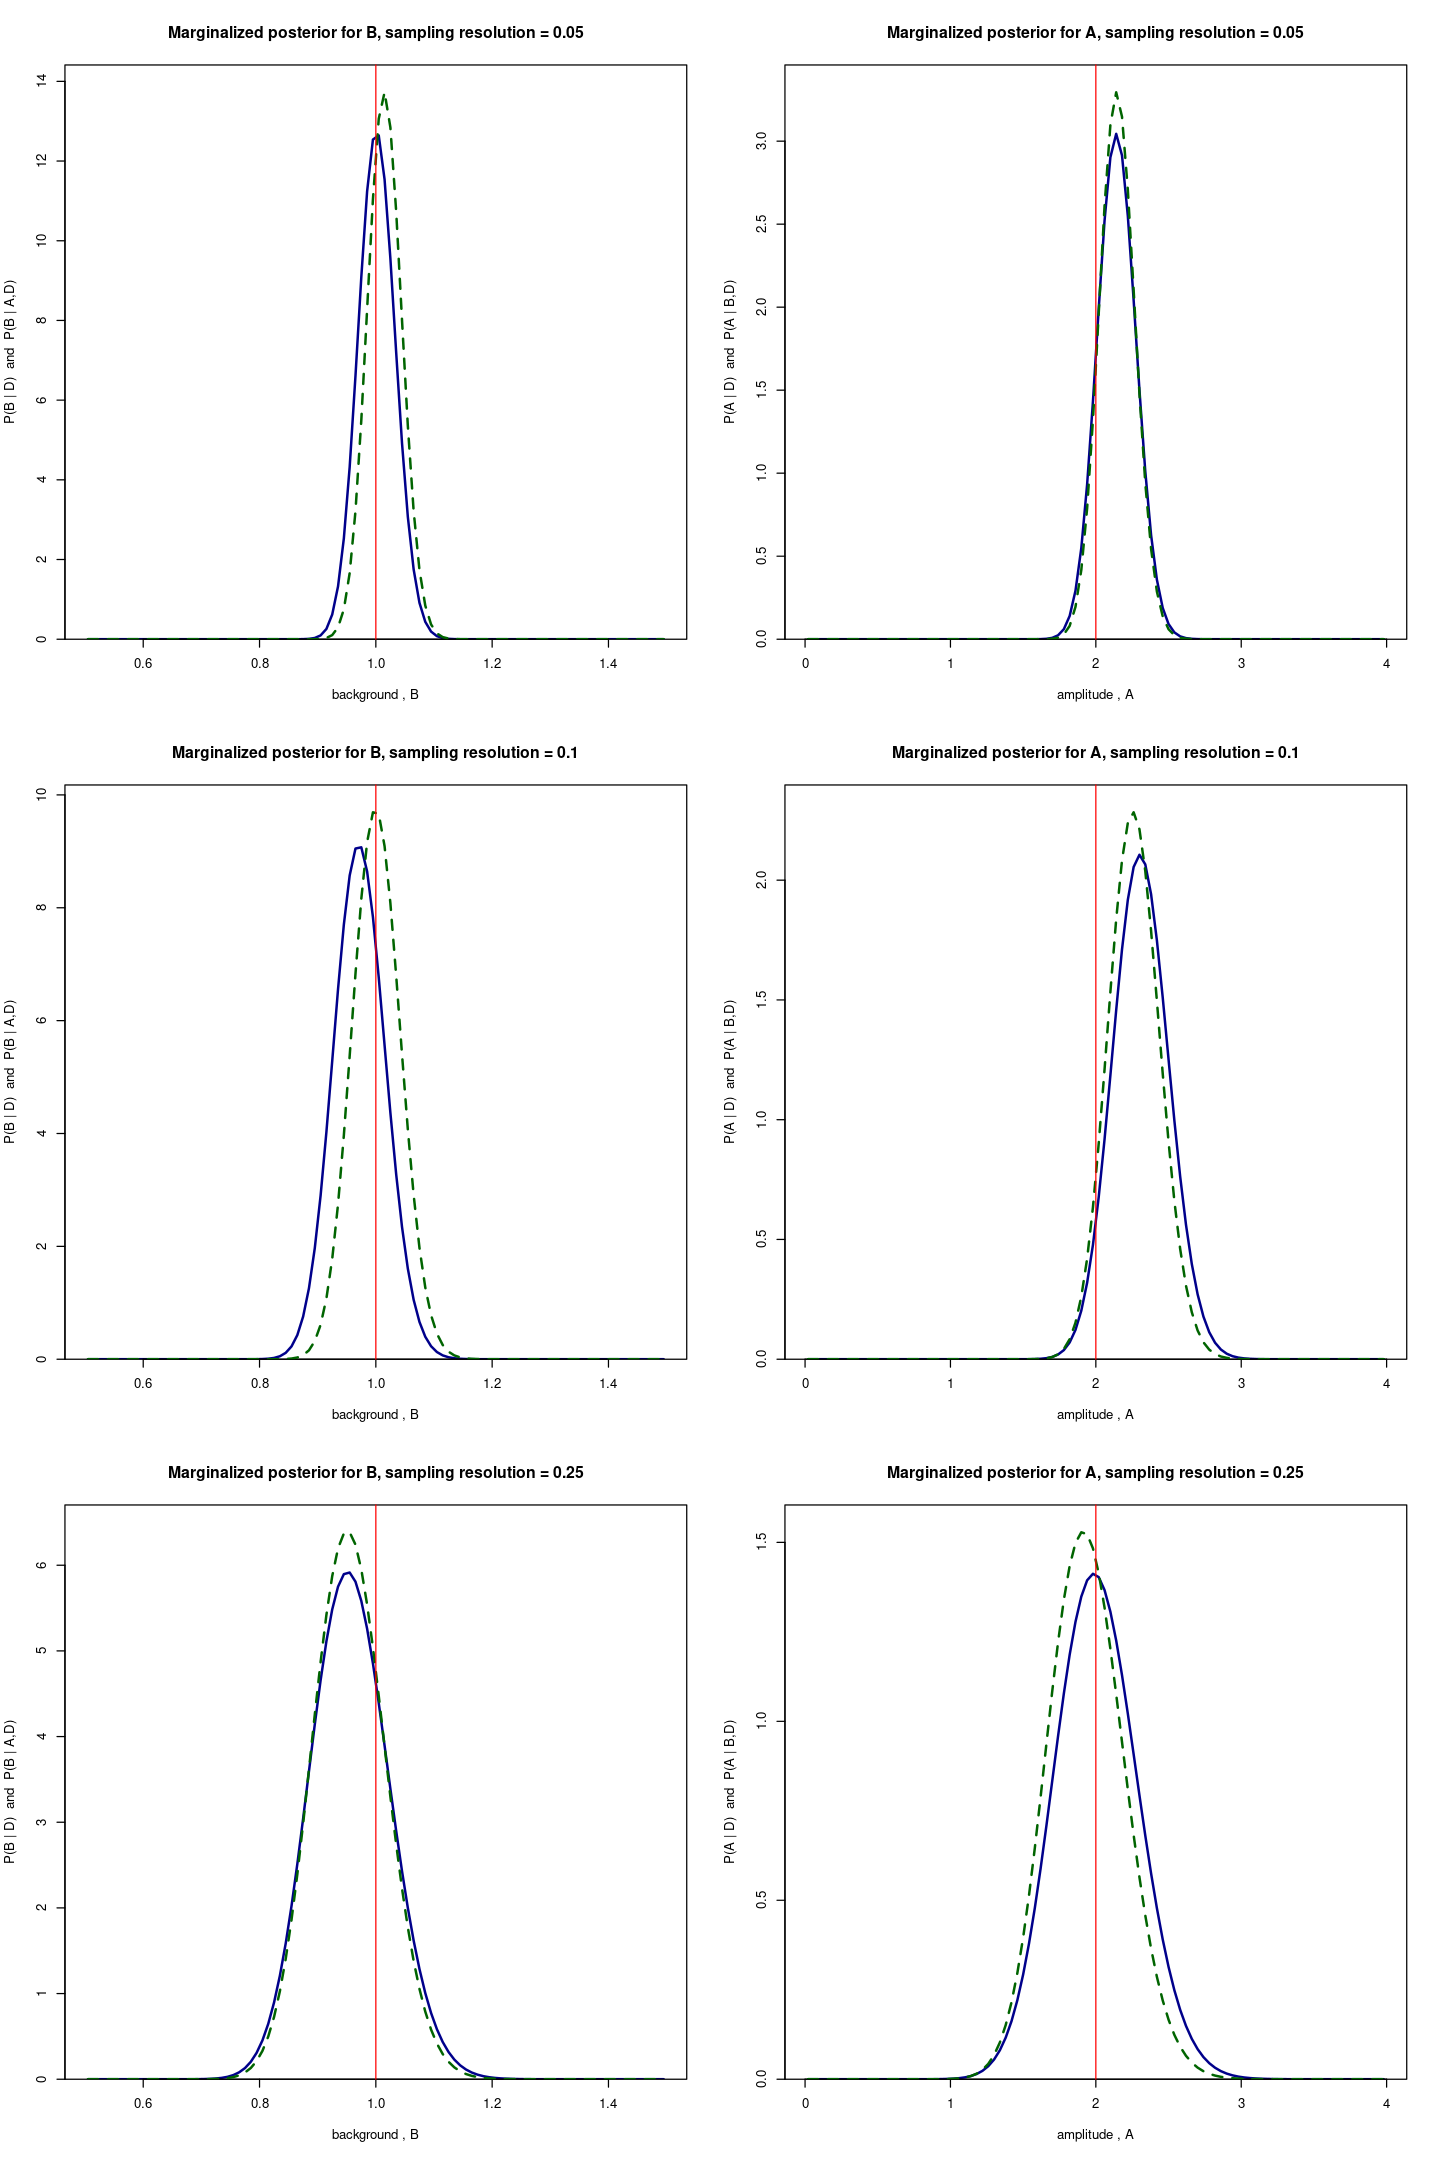

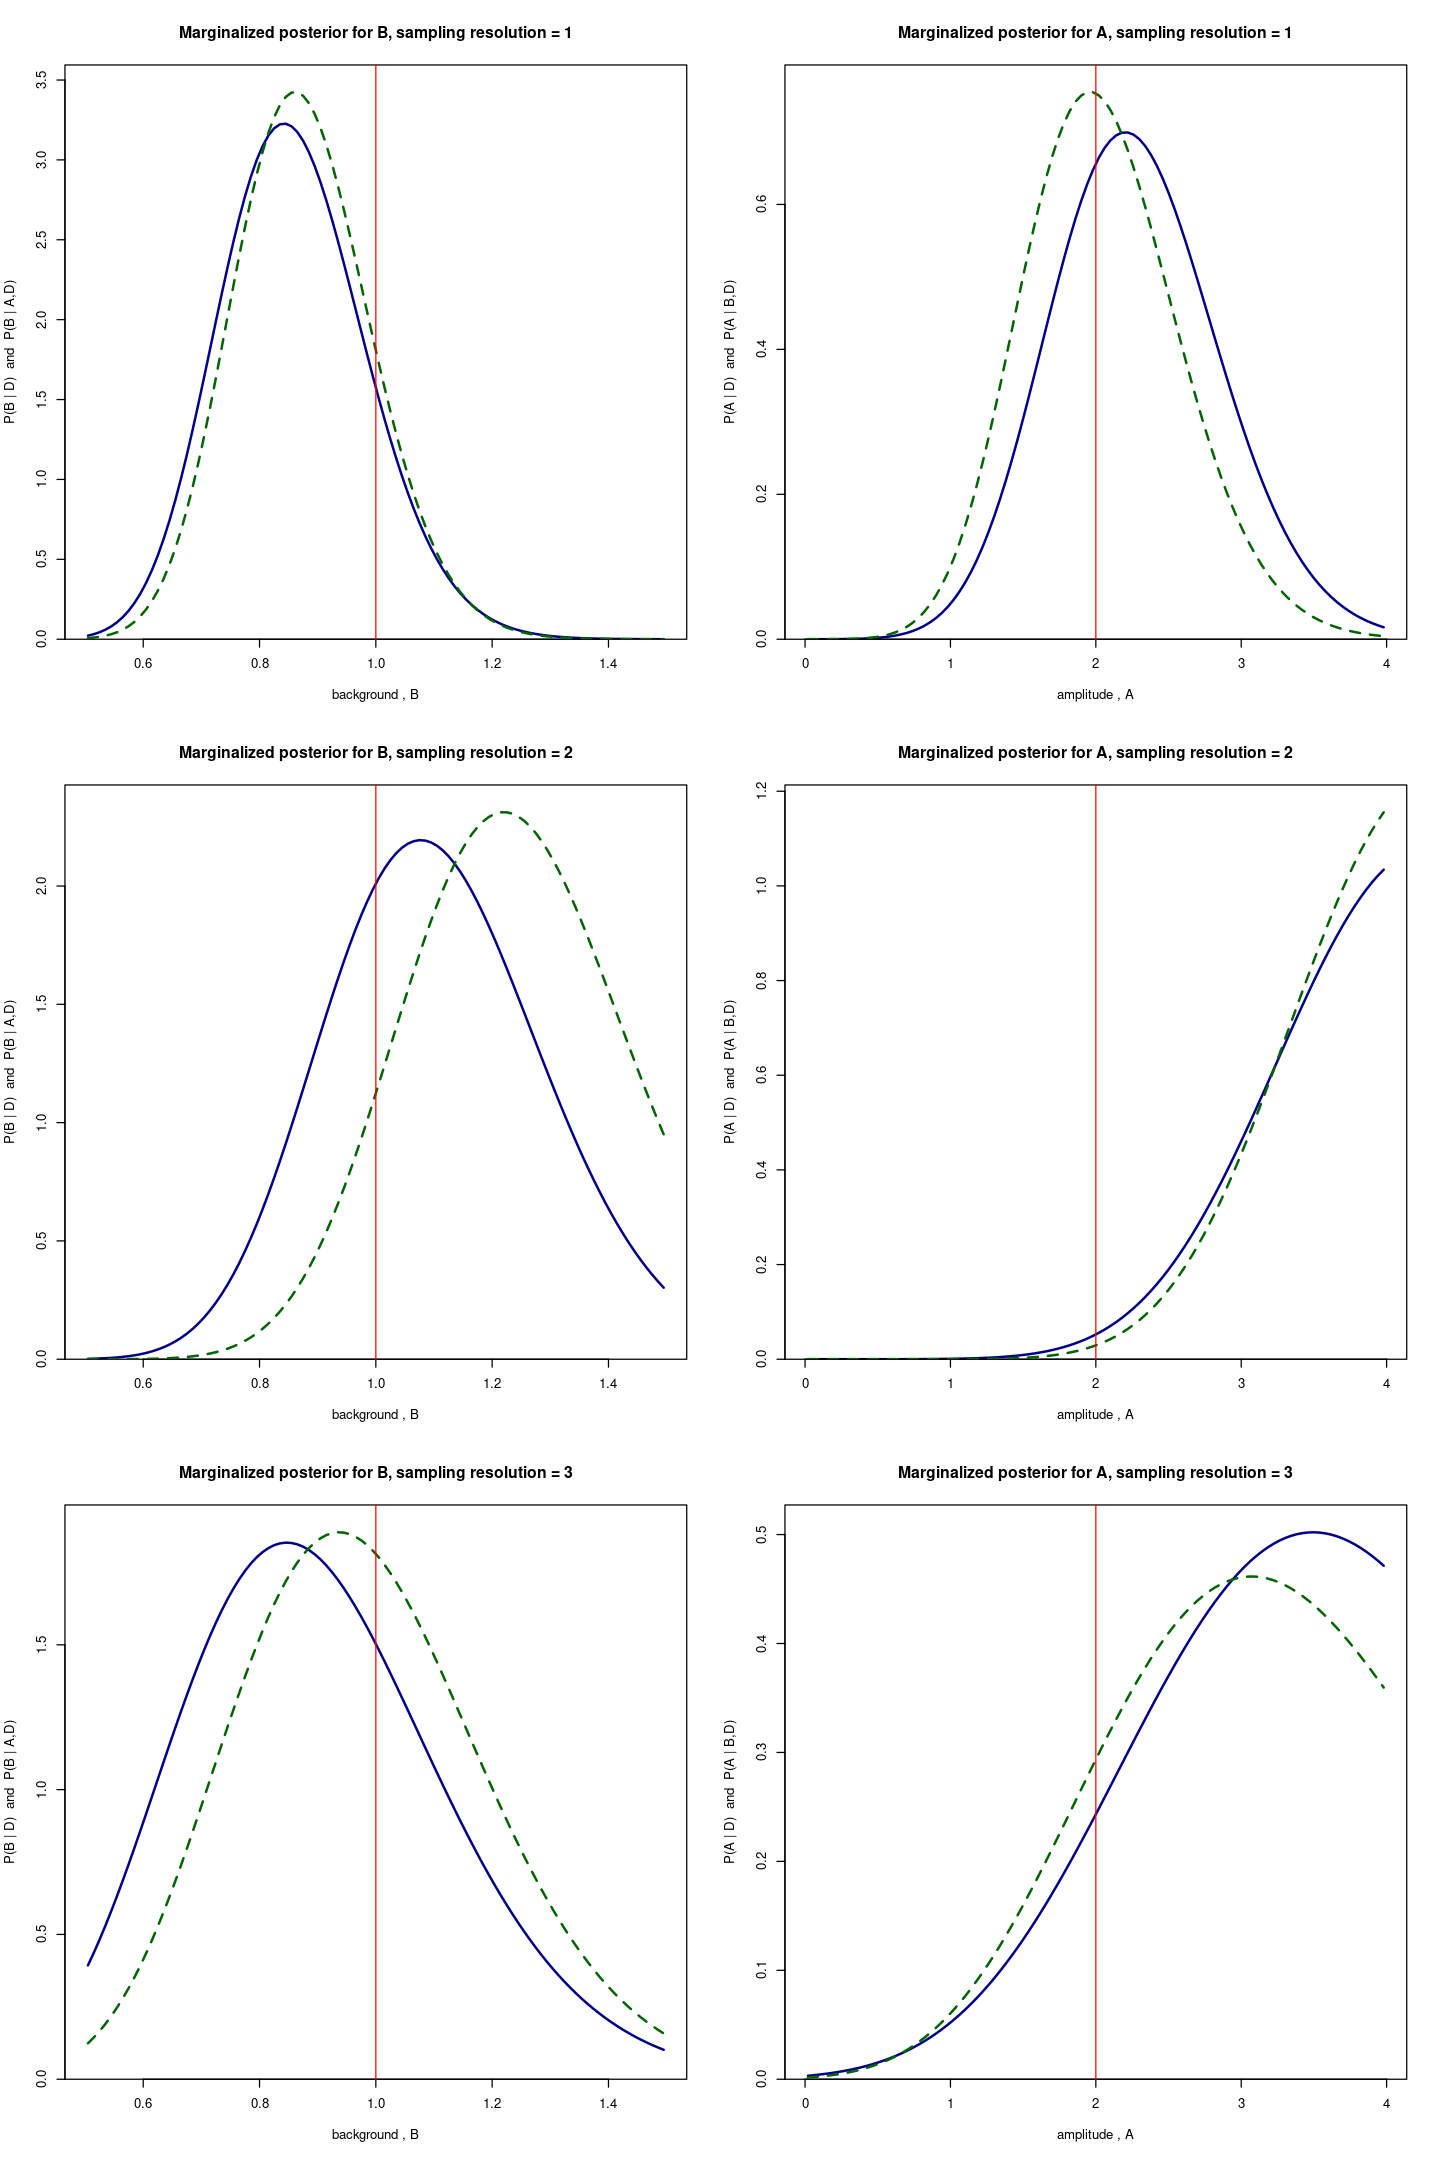

In [87]:
delta_a <- (max(a)-min(a))/nsample
delta_b <- (max(b)-min(b))/nsample

options(repr.plot.width=12, repr.plot.height=18)
par(mfrow=c(3,2))
for (i in res){
    set.seed(2022461)
    xdat  = seq(from=-7*w, to=7*w, by=i*w)
    s_true = signal(xdat, A_true, B_true , x0, w, delta_t)
    ddat  = rpois(length(s_true), s_true)
    
    # Compute log unnormalized posterior , z = ln P*(a,b|D), on a regular grid
    
    z = matrix(data=NA , nrow=length(a), ncol=length(b))
    for(j in 1:length(a)) {
        for(k in 1:length(b)) {
            z[j,k] = log_post(ddat, xdat, a[j], b[k], x0, w, delta_t)
        }
    }
    z = z - max(z) # set maximum to zero

    # Compute normalized marginalized posteriors , P(a|D) and P(b|D)
    # by summing over other parameter. Normalize by gridding.
    
    p_a_D = apply(exp(z), 1, sum)
    p_a_D = p_a_D/(delta_a*sum(p_a_D))
    p_b_D <- apply(exp(z), 2, sum)
    p_b_D <- p_b_D/(delta_b*sum(p_b_D))
    
    # Compute normalized conditional posteriors , P(a|b,D) and P(b|a,D)
    # using true values of conditioned parameters. Vectorize(func , par)
    # makes a vectorized function out of func in the parameter par.

    p_a_bD = exp(Vectorize(log_post , "a")(ddat, xdat, a, B_true, x0, w, delta_t))
    p_a_bD = p_a_bD/(delta_a*sum(p_a_bD))
    p_b_aD = exp(Vectorize(log_post , "b")(ddat, xdat, A_true, b, x0, w, delta_t))
    p_b_aD = p_b_aD/(delta_b*sum(p_b_aD))
    
    
    # Plot the 1D marginalized posteriors
    plot(b, p_b_D, xlab="background , B", yaxs="i", ylim=1.05*c(0,max(p_b_D, p_b_aD)), ylab="P(B | D)  and  P(B | A,D)",
        type="l", lwd=2, main = sprintf('Marginalized posterior for B, sampling resolution = %g', i), col = 'darkblue')
    lines(b, p_b_aD, lwd=2, lty=2, col = 'darkgreen')
    abline(v=B_true , col="red")
    
    plot(a, p_a_D, xlab="amplitude , A", yaxs="i", ylim=1.05*c(0,max(p_a_D, p_a_bD)), ylab="P(A | D)  and  P(A | B,D)",
         type="l", lwd=2, main = sprintf('Marginalized posterior for A, sampling resolution = %g', i), col = 'darkblue')
    lines(a, p_a_bD, lwd=2, lty=2, col = 'darkgreen')
    abline(v=A_true , col="red")
    
}

#### Change the ration A/B used to simulate the data